# Individual Recommender Systems - Tutorial 1 (Lab 1)


In this tutorial, we will see some implementations of strategies for individual recommender systems seen in the first lectures of the course. At the same time, we will introduce some libraries useful for machine learning applications in python. After completing this tutorial, you will be able to: 
- Create a non-personalized recommender system in the domain of movies for individual users.
- Create a personalized recommender system using either a content based or a collaborative filtering approach.
- Evaluate the performance of the recommender systems, using different evaluation protocols.


#### Summary

1. Dataset
2. Non personalized recommendations: ordering by average rating
3. Towards personalization: Filtering by genre
4. Content Based Recommender System
5. Collaborative Filtering Recommender System
6. Evaluation of Recommender Systems
    1. Evaluation of a CB recommender
    2. Evaluation of a CF recommender



#### 1. Dataset


We will use the preprocessed dataset provided in the folder *preprocessed_dataset*. The dataset has been obtained from the 
[Movielens latest small](https://www.kaggle.com/grouplens/movielens-latest-small) dataset (providing user's ratings) and the [Wikipedia Movie Plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) dataset (providing movies' information). Check the notebook **Dataset Preprocessing** for details on how the datasets have been preprocessed and merged.

The dataset contains two CSV files, following  the structure of the Movielens dataset:
1. ratings.csv: contains the information about the feedback of the users for the movies. Each row contains the id of a user,the id of a movie, and the rating that the user gave to the movie. It also contains the timestamp, but we will not use it in this tutorial.
2. movies.csv: contains the information about the movies. In particular, we will use the genre and the plot.



We start using the [pandas](https://pandas.pydata.org/) library to read the content of the CSV files and use it. Let us have a look at the first 10 rows of each file, to check which contents are provided by the *ratings.csv* and the *movies.csv* files. To do so, we use the *read_csv* method which returns a pandas [Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) object containing the information read from the csv file. Such object provides several methods to manipulate the data in it, and we will use the [head](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) method, which returns the first *n* rows of the dataframe. We use also the [display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display) method, that allows to print information nicely in a jupyter notebook.

In [4]:
preprocessed_dataset_folder = "../preprocessed_dataset"

import pandas as pd

In [5]:
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv") 
display(ratings_df.head(10))

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,70,3.0,964982400
4,1,101,5.0,964980868
5,1,110,4.0,964982176
6,1,151,5.0,964984041
7,1,157,5.0,964984100
8,1,163,5.0,964983650
9,1,216,5.0,964981208


In [6]:
movies_df = pd.read_csv(preprocessed_dataset_folder+"/movies.csv", index_col="item")
display(movies_df.head(10))

,title,year,genres,plot
item,,,,
1,toy story,1995,Adventure|Animation|Children|Comedy|Fantasy,In a world where toys are living things who pr...
2,jumanji,1995,Adventure|Children|Fantasy,"In 1869, near Brantford, New Hampshire, two br..."
3,grumpier old men,1995,Comedy|Romance,The feud between Max (Walter Matthau) and John...
4,waiting to exhale,1995,Comedy|Drama|Romance,"""Friends are the People who let you be yoursel..."
5,father of the bride part ii,1995,Comedy,The film begins five years after the events of...
6,heat,1995,Action|Crime|Thriller,"Neil McCauley, a career criminal, hires Waingr..."
7,sabrina,1995,Comedy|Romance,Sabrina Fairchild is the young daughter of the...
8,tom and huck,1995,Adventure|Children,The movie opens with Injun Joe (Eric Schweig) ...
9,sudden death,1995,Action,Darren McCord (Jean-Claude Van Damme) is a Fre...


Let us have a look at the number of ratings we have for each movie. First, we select the columns *user* and *item*. Then, we can use the [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method to group the columns given a specific column value. The method returns a [Groupby](https://pandas.pydata.org/docs/reference/groupby.html) object, which provides methods to aggregate the values of each group. We aggregate by *item*, to count the number of users that rated each item. To compute this, we use the [count](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.count.html) method which returns a Dataframe object, in which we will have a row for each movie, and the number of users who rated each movie in the *user* column.

Then, we visualize the distribution of the number of evaluations for each movie using the [seaborn](https://seaborn.pydata.org/) library. We use the [displot](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.displot) method, specifying `x='user'`.

,user
item,
1,215
2,110
3,52
4,7
5,49
...,...
181315,1
182823,4
191005,1


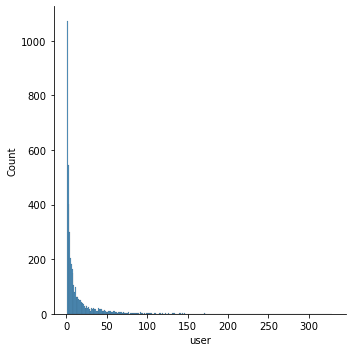

In [7]:
import seaborn as sns

count_ratings_df = ratings_df[['user','item']].groupby(['item']).count()
display(count_ratings_df)
sns.displot(data=count_ratings_df, x='user', binwidth=1)

Note that here, we have on the horizontal axe the number of users that evaluated a movie, and on the vertical axe the number of movies having the corresponding number of evaluations. We migh want to visuaize instead on the horizontal axe the movies, and on the vertical axe the number of users who evaluated it. There are different ways to do it, we will just sort the previous Dataframe by *user* (i.e. the number of user evaluations for the corresponding movie) in a descending order, using the [sort_values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method of the Dataframe object, and then reset the index two times, in order to have a progressive id for the movies (the [reset_index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) function will create a nerw index assigning a progressive identifier to each row in the Dataframe). The, we just plot the line having *index* on the horizontal axe and *user* on the vertical axe. 

,index,item,user
0,0,356,329
1,1,296,307
2,2,480,238
3,3,110,237
4,4,589,224
...,...,...,...
4620,4620,44197,1
4621,4621,4402,1
4622,4622,44189,1
4623,4623,4408,1


<AxesSubplot:xlabel='index', ylabel='user'>

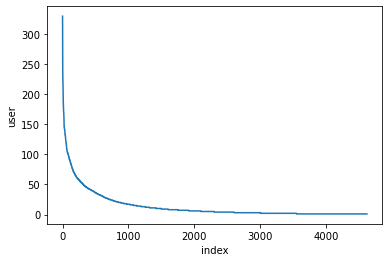

In [8]:
count_ratings_df_ord = count_ratings_df.sort_values(by="user", ascending=False).reset_index().reset_index()
display(count_ratings_df_ord)
sns.lineplot(data=count_ratings_df_ord, x='index', y='user')

Is this what you expected? Does this reming you of something?

![title](img/The-long-tail-dinosaur.png)

#### 2. Non personalized recommendations: ordering by average rating

A first idea to provide recommendations for our users can be to use the ratings provided and determine the highest rated movies. To do so, we first need to compute the average rating for each movie, and then determine the top rated. Let's use again the functions provided by the Dataframe object. We can use the [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) again. To compute the average ratings, we use the [mean](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.mean.html) method which returns a Dataframe object, in which we will have a row for each movie, and the average rating will be in the *rating* column. Finally, we use the [sort_values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method to sort the movies by rating, and we print the first 10 movies.

In [9]:
average_ratings_df = ratings_df.groupby(['item']).mean()
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False)

display(sorted_avg_ratings_df.head(10))

,user,rating,timestamp
item,,,
4402,441.0,5.0,1.449071e+09
96608,89.0,5.0,1.520409e+09
131237,105.0,5.0,1.446619e+09
33138,187.0,5.0,1.161955e+09
84512,89.0,5.0,1.520409e+09
82744,380.0,5.0,1.493422e+09
164367,534.0,5.0,1.487278e+09
99636,106.0,5.0,1.467567e+09
107771,610.0,5.0,1.479544e+09


Let's use the information in the *movies_df* to associate the title on each movie, and then print the list of recommended movies. We will use the [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method of the Dataframe object. Remember that the attribute you specify with the *on* parameter must be the index of the second dataframe.

In [10]:
joined_df = sorted_avg_ratings_df.join(movies_df, on='item')
display(joined_df.head(10))

,user,rating,timestamp,title,year,genres,plot
item,,,,,,,
4402,441.0,5.0,1.449071e+09,dr. goldfoot and the bikini machine,1965,Comedy,"Price plays the titular mad scientist who, wit..."
96608,89.0,5.0,1.520409e+09,runaway brain,1995,Animation|Comedy|Sci-Fi,Minnie visits Mickey while he is playing a Sno...
131237,105.0,5.0,1.446619e+09,what men talk about,2010,Comedy,"What Men Talk About? Of course, women. But als..."
33138,187.0,5.0,1.161955e+09,palindromes,2004,Adventure|Comedy|Drama,The film opens with a funeral for a young woma...
84512,89.0,5.0,1.520409e+09,girls about town,1931,Comedy,Wanda Howard (Kay Francis) and Marie Bailey (L...
82744,380.0,5.0,1.493422e+09,faster,2010,Action|Crime|Drama,"Upon leaving prison, ""Driver"" breaks into a ru..."
164367,534.0,5.0,1.487278e+09,the girl with all the gifts,2016,Drama|Horror|Sci-Fi|Thriller,"In the near future, humanity has been ravaged ..."
99636,106.0,5.0,1.467567e+09,english vinglish,2012,Comedy|Drama,Shashi Godbole (Sridevi) is a homemaker who ma...
107771,610.0,5.0,1.479544e+09,only lovers left alive,2013,Drama|Horror|Romance,Married for centuries and now living half a wo...


The movie we recommend are not so famous. Why is this happening? Let's check how many people rated each of these movies. We use again the *group_by* method, and then we use the [agg](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.agg.html) method of the Groupby onject to specify different aggregations: for the *user*, we are going to count the number of users in the group, using the *'size'* input, while for the rating we want the average value, so we specify *'mean'*. The rest of the operations are the same as before:

In [11]:
average_ratings_df = ratings_df.groupby(['item']).agg(count=('user', 'size'), rating=('rating', 'mean')).reset_index()
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False)
joined_df = sorted_avg_ratings_df.join(movies_df, on='item')
display(joined_df[['title', 'count', 'rating']].head(10))

,title,count,rating
1910,dr. goldfoot and the bikini machine,1,5.0
4055,runaway brain,1,5.0
4377,what men talk about,1,5.0
3164,palindromes,1,5.0
3881,girls about town,1,5.0
3869,faster,1,5.0
4532,the girl with all the gifts,1,5.0
4097,english vinglish,1,5.0
4200,only lovers left alive,1,5.0
4113,maniac cop 2,1,5.0


We can see that all the movies we selected have been rated by only one user. Let's try to recommend only movies that have been rated by at least 20 users. Note that the *item* column is the index for the Dataframe object obtained using the *mean* and *count* methods. We will use the [loc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) attribute of the Dataframe object, which allows to access a group of rows and columns by label(s) or a boolean array. In particular, we will determine a Series of boolean: The instruction `rating_counts_df['rating'] > minimum_ratings` evaluate the condition for each row of the *rating* column. Hence, *loc* will only return the rows for which such condition is true.

In [12]:
minimum_ratings = 20
average_ratings_df = ratings_df.groupby(['item']).mean() #compute the average ratings for each movie
rating_counts_df = ratings_df.groupby(['item']).count() #compute the number of evaluations for each movie
average_ratings_df = average_ratings_df.loc[rating_counts_df['rating'] > minimum_ratings] #select the movies having the required number of evaluations
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False) #sort the movies according to the average ratings
joined_df = sorted_avg_ratings_df.join(movies_df['title'], on='item') #associate the title
display(joined_df[['title','rating']].head(10))

,title,rating
item,,
1204,lawrence of arabia,4.300000
1235,harold and maude,4.288462
168252,logan,4.280000
2959,fight club,4.272936
1276,cool hand luke,4.271930
750,dr. strangelove or: how i learned to stop worr...,4.268041
904,rear window,4.261905
1213,goodfellas,4.250000
912,casablanca,4.240000


We can see now that the recommendation contains more famous movies.

#### 3. Towards personalization: filtering by genre

Now, let us try to make a personalized recommender system. One possible solution is to suggest movies having the highest ratings for a specific genre. We also want to only select movies evaluated by at least 20 users. We use the same methods used in the previous example. To select the movies by genre, we need to check if the value in the column *genre* contains the specified genre. We can write the conditions as `average_ratings_df['genres'].str.contains(genre)`. 

In [13]:
genre = 'Action'
minimum_ratings = 20

average_ratings_df = ratings_df.groupby(['item']).mean() #compute the average ratings for each movie
rating_counts_df = ratings_df.groupby(['item']).count() #compute the number of evaluations for each movie
average_ratings_df = average_ratings_df.loc[rating_counts_df['rating'] > minimum_ratings] #select the movies having the required number of evaluations
average_ratings_df = average_ratings_df.join(movies_df['genres'], on='item')
average_ratings_df = average_ratings_df.loc[average_ratings_df['genres'].str.contains(genre)]
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False) #sort the movies according to the average ratings
joined_df = sorted_avg_ratings_df.join(movies_df['title'], on='item') #associate the title
display(joined_df[['title','rating','genres']].head(10))

,title,rating,genres
item,,,
168252,logan,4.280000,Action|Sci-Fi
2959,fight club,4.272936,Action|Crime|Drama|Thriller
1208,apocalypse now,4.219626,Action|Drama|War
908,north by northwest,4.184211,Action|Adventure|Mystery|Romance|Thriller
2028,saving private ryan,4.146277,Action|Drama|War
68157,inglourious basterds,4.136364,Action|Drama|War
541,blade runner,4.100806,Action|Sci-Fi|Thriller
79132,inception,4.066434,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
112852,guardians of the galaxy,4.050847,Action|Adventure|Sci-Fi


We can see here the genres associated to the chosen movies. A movie can belong to multiple genres, some of which a user likes, and some he/she dislike. 

#### 4. Content Based Recommender System

Let us try to implement a strategies seen during the lectures to provide more personalized recommendations. We start from a content based approach. In the next steps, we will implementing a CB recommender for a specific user, and generate a recommendation list considering the movies the user didn't rate. We will see the following steps:
- Selection of a random user
- Retrieving the information of the rated and unrated movies for the selected user
- Compute a feature representation for the movie's contents (TF-IDF)
- Train a regressor, compute the predicted ratings for unrated movies, and recommending the movies with higher predicted ratings

##### 4.1 Selection of a random user


For simplicity, we select a random user from the *ratings_df* Dataframe having more than 200 evaluations. First, we select all the users with more than 200 evaluations, and then we use the [sample](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.sample.html) method to extract a random row. Finally, we extract the *user* column and we read the content with the [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) method.

In [14]:
users_ratings = ratings_df.groupby(['user']).count()

selected = users_ratings['rating'] > 200
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample() # sample() returns a random row from the dataframe. The returned object is a dataframe with one row. If you pass a number as argument you specify to select more than one row.
select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the user became a column. Then, we can filter using the column name
selected_user = select_column_df.iloc[0] # iloc select by index, since our dataframe only has one row we read it from the index 0
print("Selected user: " + str(selected_user))

Selected user: 414


##### 4.2 Retrieving the information of the rated and unrated movies for the selected user

Now, we need to select the user evaluations, that we will use to train our recommender. We print the number of ratings that we have for the considered user, and the extracted dataset, ordered by ratings.

In [15]:
selected_user_ratings = ratings_df.loc[ratings_df['user'] == selected_user]
selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
print("Rated movies: " + str(selected_user_ratings.shape[0]))
display(selected_user_ratings.head(10))

Rated movies: 1738


,user,item,rating,timestamp
39961,414,1,4.0,961438127
39962,414,2,3.0,961594981
39963,414,3,4.0,961439278
39964,414,5,2.0,961437647
39965,414,6,3.0,961515642
39966,414,7,3.0,961439170
39967,414,8,3.0,961594849
39968,414,10,3.0,961515863
39969,414,15,2.0,961514611
39970,414,16,3.0,961517557


Now, we need the select content of the rated movies, that we will need to compute the features that our model will use. We do it by selecting the rows from our *movies_df* dataframe having a *item* that is in the list of *item* of the *selected_user_ratings* Dataframe, which only contains the evaluations of the considered user. We do this using the [isin](https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html) method. Since the *item* is the index in the *movies_df* Dataframe, we can select directly pass the list of *item* we want to select to *loc*, and it will return the rows for which the index is in the considered list. Finally, we only select the columns *title* and *plot*.

In [16]:
rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])]
rated_movies_df = rated_movies_df[['title', 'plot']]
print("Rated movies: " + str(rated_movies_df.shape[0]))
display(rated_movies_df.head(10))

Rated movies: 1738


,title,plot
item,,
1,toy story,In a world where toys are living things who pr...
2,jumanji,"In 1869, near Brantford, New Hampshire, two br..."
3,grumpier old men,The feud between Max (Walter Matthau) and John...
5,father of the bride part ii,The film begins five years after the events of...
6,heat,"Neil McCauley, a career criminal, hires Waingr..."
7,sabrina,Sabrina Fairchild is the young daughter of the...
8,tom and huck,The movie opens with Injun Joe (Eric Schweig) ...
10,goldeneye,"In 1986, at Arkhangelsk, MI6 agents James Bond..."
15,cutthroat island,"In 1668 Jamaica, Morgan Adams hunts down her u..."


We use a similar approach to select the unrated movies. We compute the set of movies index that are not rated using the set subtraction operator. We access the index of the *movies_df* and the *rated_movies_df* Dataframes, create two sets containing such indexes, compute the difference set *diff*, and select the movies having an  index in the *diff* set.

In [17]:
diff = set(movies_df.index) - set(rated_movies_df.index)
unrated_movies_df = movies_df.loc[diff]
unrated_movies_df = unrated_movies_df[['title', 'plot']]
print("Unrated movies: " + str(unrated_movies_df.shape[0]))
display(unrated_movies_df.head(10))

Unrated movies: 2895


<ipython-input-17-209a49fb22e2>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  unrated_movies_df = movies_df.loc[diff]


,title,plot
item,,
4,waiting to exhale,"""Friends are the People who let you be yoursel..."
8196,beyond the valley of the dolls,"Three young women—Kelly MacNamara, Casey Ander..."
8197,hiroshima mon amour,Hiroshima mon amour concerns a series of conve...
122884,insidious: chapter 3,"Several years before The Lambert Haunting, ret..."
180231,daddy's home 2,After finally becoming friends at the end of t...
9,sudden death,Darren McCord (Jean-Claude Van Damme) is a Fre...
122890,warcraft,"Draenor, the homeworld of the orcs, is being t..."
155659,florence foster jenkins,Florence Foster Jenkins (Meryl Streep) is a Ne...
12,dracula: dead and loving it,Solicitor Thomas Renfield travels all the way ...


Finally, we can add the rating so that we just need to work with a single Dataframe. We do it using the *join* method. We specify the *item* as idex in the *selected_user_ratings* Dataframe to procede with the join. The we select the *rating* column.

In [18]:
rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('item')['rating'], on='item')
print("Rated movies: " + str(rated_movies_df.shape[0]))
display(rated_movies_df.head(10))

Rated movies: 1738


,title,plot,rating
item,,,
1,toy story,In a world where toys are living things who pr...,4.0
2,jumanji,"In 1869, near Brantford, New Hampshire, two br...",3.0
3,grumpier old men,The feud between Max (Walter Matthau) and John...,4.0
5,father of the bride part ii,The film begins five years after the events of...,2.0
6,heat,"Neil McCauley, a career criminal, hires Waingr...",3.0
7,sabrina,Sabrina Fairchild is the young daughter of the...,3.0
8,tom and huck,The movie opens with Injun Joe (Eric Schweig) ...,3.0
10,goldeneye,"In 1986, at Arkhangelsk, MI6 agents James Bond...",3.0
15,cutthroat island,"In 1668 Jamaica, Morgan Adams hunts down her u...",2.0


Now, we have all the data we need to train a content based recomemnder system for our user.

##### 4.3 Compute a feature representation for the movie's contents (TF-IDF)

We will use the well-known pythion library [sklearn](https://scikit-learn.org/stable/) to train our recommender. First, we need to extract features from our content (the plots of the movies). Remember that we need a vector representing each document, in order to compare them. We use the TF-IDF model, hance we will use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class, which allows us to easily compute TF-IDF vectors for our movies. We need to instantiate the a *TfidfVectorizer* object, and then we need to use the [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform) method. The method fits (trains) the features model, and then transform our data, returning the TF-IDF matrix representation. We use the [shape](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html#numpy.ndarray.shape) attribute of the matrix to check the dimensions of our features matrix.

In [19]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['plot'])
print(X.shape)

(1738, 38016)


##### 4.4 Train a regressor, computing of the predicted ratings for unrated movies, and recommending the movies with higher predicted ratings

Now, we have our features. In this example, we will train a regressor, that is able to determine, for each unrated movie, an extimation of the rating that the user would assign to it. Of course, we could use a different approach, treating the problem as a classification problem. In that case, we would need to transform our ratings to obtain labels. We will see that later today. Now, for simplicity, we will work with the ratings. 

For the regressor, we will use the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) class of the sklearn library. We need to create an instance of *KNeighborsRegressor*. Remember that the KNN algorithm uses the similarity between items to compute the predictions. In the case of regression, the rating assigned to new item is computed based on the mean of the ratings of its nearest neighbors.

In the constructor, we specify the number of neighbors to use. We set it at 5. Finally, we can train our model, using the [fit](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.fit) method, passing as arguments the features matrix *X* and the corresponding ratings vector *y*.

In [20]:
from sklearn.neighbors import KNeighborsRegressor

y = rated_movies_df['rating']
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

KNeighborsRegressor()

We can now use the trained model to compute our recommendations. First, we need to extract the features from our unrated movies plots. We can do it using the previously trained *TfidfVectorizer* *vectorizer*, passing to its method [transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) the *Plot* column if the *unrated_movies* Dataframe. 

Then, we use the trained *KNeighborsRegressor* *neigh*, passing the features matrix of the unrated movies *x_unrated* to its [predict](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict) method, determining the predicted ratings *y_unrated*.

In [21]:
X_unrated = vectorizer.transform(unrated_movies_df['plot'])
print(X_unrated.shape)
y_unrated = neigh.predict(X_unrated)
print(y_unrated.shape)

(2895, 38016)
(2895,)


Finally, we can combine the predicted ratings with the information in the unrated_movies Dataframe, order the movies by predicted ratings, and determine the best 10 movies to recommend to the user.

In [22]:
unrated_movies_df['predicted_ratings_KNN'] = y_unrated
unrated_movies_df_KNN_ordering = unrated_movies_df.sort_values(by='predicted_ratings_KNN', ascending=False)
display(unrated_movies_df_KNN_ordering.head(10))

,title,plot,predicted_ratings_KNN
item,,,
4255,freddy got fingered,"Unemployed 28-year-old cartoonist Gordon ""Gord...",4.6
111617,blended,Divorcee Lauren Reynolds goes on a blind date ...,4.6
51933,pride,It is 1974 and life is not easy for a black ma...,4.6
3628,flying tigers,Jim Gordon (John Wayne in his first war film) ...,4.6
155820,keanu,Smoke and Oil Dresden (Jordan Peele and Keegan...,4.6
170945,it comes at night,A highly contagious outbreak has ravaged the w...,4.5
5189,humanoids from the deep,"Anglers from the fishing village of Noyo, Cali...",4.4
243,gordy,A piglet named Gordy lives a happy life on Mea...,4.4
101739,evil dead,"In the woods, several men capture a frightened...",4.4


#### EXERCISE

Following the example above, implement a second content-based recommender system using the [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) regressor of the Sklearn library (use a *linear* kernel and the default hyperparameters).

##### Solution

#### 5. Collaborative Filtering Recommender System

As we highlighted in the lectures, content based approaches suffers from some limitations (do you remember some?). Collaborative filtering approaches use the "wisdom of the crowd" to recommend items, following the assumption that different users with similar tastes in the past, will probably have similar tastes in the future. Hence, without the need of external information, but only looking at the interactions of for similar users (or movies) we can predict the rating of an unseen movie for an user.

Also, in this case, we will not implement the strategy, but we will use a library. In particular, we are going to use the [Lenskit](https://lkpy.readthedocs.io/en/stable/) library. Note that such library requires the python 3.6 version. We will focus on the user-user recommender, while, as exercise, you will have to use the item-item strategy.

##### 5.1 Collaborative user-user recommender with Lenskit

We use the collaborative user algorithm [UserUser](https://lkpy.readthedocs.io/en/stable/knn.html#module-lenskit.algorithms.user_knn), that uses the nearest neighbors algorithm. The constructor takes as inputs the maximum and minumum number of neighbors to consider (we set them to 15 and 3). Then we use the [adapt](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Recommender.adapt) method of the [Recommender](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Recommender) class, to obtain a *Recommender* object. Then, we can use the [fit](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Algorithm.fit) method to train the model. 

In [23]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser

# We use the collaborative user algorithm UserUser, that use the nearest neighbors 
num_recs = 10  # Number of recommendations to generate
user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(ratings_df)

Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


Now, we can provide the recommendations for a specific user. Let's generate 10 recommendations for the user selected for the previous example. We use the [recommend](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Recommender.recommend) method of the *Recommender* class to generate the recommendations. Then, we add the title information and display the recommendations.

In [24]:
selected_movies_useruser = recsys.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
display(selected_movies_useruser)

,item,score,title
0,7121,4.650066,adam's rib
1,3030,4.628392,yojimbo
2,5833,4.541522,dog soldiers
3,4021,4.540886,before night falls
4,1236,4.531006,trust
5,3451,4.476842,guess who's coming to dinner
6,3925,4.466906,stranger than paradise
7,3494,4.444916,true grit
8,1411,4.440527,hamlet
9,7706,4.424440,animal crackers


We can compare such recommendations with the one previously computed with the content based approach.

In [25]:
display(unrated_movies_df_KNN_ordering.head(10))

,title,plot,predicted_ratings_KNN
item,,,
4255,freddy got fingered,"Unemployed 28-year-old cartoonist Gordon ""Gord...",4.6
111617,blended,Divorcee Lauren Reynolds goes on a blind date ...,4.6
51933,pride,It is 1974 and life is not easy for a black ma...,4.6
3628,flying tigers,Jim Gordon (John Wayne in his first war film) ...,4.6
155820,keanu,Smoke and Oil Dresden (Jordan Peele and Keegan...,4.6
170945,it comes at night,A highly contagious outbreak has ravaged the w...,4.5
5189,humanoids from the deep,"Anglers from the fishing village of Noyo, Cali...",4.4
243,gordy,A piglet named Gordy lives a happy life on Mea...,4.4
101739,evil dead,"In the woods, several men capture a frightened...",4.4


#### EXERCISE

Following the example above, implement a second collaborative filtering recommender system using the [ItemItem](https://lkpy.readthedocs.io/en/stable/knn.html#lenskit.algorithms.item_knn.ItemItem) collaborative user algorithm provided by the Sklearn library.

##### Solution

#### 6. Evaluation of Recommender Systems

We have seen different approaches, but how can we evaluate the godness of the proposed recommendations? We are going to see now some examples, focusing on the two personalized approaches (content based and collaborative filtering).

The content based recommender system is specific for each user; hence, we would need to evaluate a model for each user, and provide an average evaluation for the approach. On the contrary, the collaborative filtering recommender trains a single model for all the users. Hence, the evaluation procedure is a bit different, and we will see an example for each. 

In the examples, we will use the holdout evaluation strategy. As exercise you will have to implement a K-Fold evaluation.

Furthermore, in the previous example, we estimated user's ratings on unseen movies, using a regressor. Now, we will see the problem as a classification problem. We will consider as relevant, for the user, all the movies rated higher than 3.

#### 6.1 Evaluation of a Content-based Recommender System

We implemented our Content-based Recommender System using the lenskit library. The same library offers a wide range of tools to evaluate regressors and classifiers, that we will use (and describe). First, let's define a support function which allows us to select the information we need for a particular user.

The function is called *get_user_rated_movies_plots* and takes as input the user, and the two Dataframe *ratings_df* and *plot_df*. It first selects the ratings of the considered user. Then, it selects the movies information for the movies evaluated by the user. Finally, it joins the information in a single Dataframe, and adds a column in which a relevance for each movie is computed, according to the correlated rating: if the user gave a rating higher than 3, the relevance is set to 1; on the contrary, the relevance is 0. 

To do this, we use the apply function of the Dataframe class (seen previously). In this case, since the operation to perform is easy, we don't define a function for it. Instead, we define a lambda function (you can see it as a small anonymous function). The lambda function is applied to each row of the dataframe on which the apply method is called. In this case, we call it on the *'rating'* column of the *rated_movies* Dataframe. Hence, x is the rating of a specific movie.

The lambda function then computes the relevance value through a [ternary operator](https://book.pythontips.com/en/latest/ternary_operators.html).

In [26]:
def get_user_rated_movies_plots(user, ratings_df, movies_df):
    """
    extract from the dataframe ratings_df the ratings of the user
    """
    selected_user_ratings = ratings_df.loc[ratings_df['user'] == user] # select the ratings of the user
    rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])] # select the movie information for the movies rated by the user
    rated_movies_df = rated_movies_df[['title', 'plot']] # select only the information we need
    selected_user_ratings = selected_user_ratings.set_index('item') # set the index for the next join
    rated_movies_df = rated_movies_df.join(selected_user_ratings['rating'], on='item') # join the two dataframes
    rated_movies_df['relevant'] = rated_movies_df['rating'].apply(lambda x: 1 if x>3 else 0) # compute the relevance values for the user
    return rated_movies_df

We can test the function retrieving the information for the user selected for the previous evaluations

In [27]:
user_plots_ratings_df = get_user_rated_movies_plots(selected_user, ratings_df, movies_df)
display(user_plots_ratings_df)

,title,plot,rating,relevant
item,,,,
1,toy story,In a world where toys are living things who pr...,4.0,1
2,jumanji,"In 1869, near Brantford, New Hampshire, two br...",3.0,0
3,grumpier old men,The feud between Max (Walter Matthau) and John...,4.0,1
5,father of the bride part ii,The film begins five years after the events of...,2.0,0
6,heat,"Neil McCauley, a career criminal, hires Waingr...",3.0,0
...,...,...,...,...
179819,star wars: the last jedi,"Shortly after the battle of Starkiller Base,[N...",4.5,1
180031,the shape of water,"Elisa Esposito, who was found in a river as an...",4.0,1
180045,molly's game,Molly Bloom is world-class mogul skier with Ol...,4.0,1


Now, since we have a different recommender for each user, we need a function that evaluates the recommender for a specific user. We will use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class from the sklearn library to compute the TD-IDF representations of the movies' plots, as we did before. But, since we are addressing the problem as a classification problem, we use the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) instead of a regressor. 

Differently from the previous example, we want to evaluate the performances of our classifier, hence we need to test it on a set of movies for which we have the correct relevance for this user. In other words, we need to split the information we have about the user ratings in two sets:
1. Training set: we will use this data to train our classifier.
2. Test set: we will apply our classifier to this data and compare the predictions with the actual relevance values.

To split the data we will use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method, provided by the sklearn library.
Finally, once we have the classifier predictions, we use the [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) method, provided by the sklearn library, to compute the information retievalmetrics *precision*, *recall* and *fscore*. The function returns such values for the considered user.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

def train_and_test_recsys_for_user(user):
    user_plots_ratings_df = get_user_rated_movies_plots(user, ratings_df, movies_df) # retrieve user info with the previously defined method
    
    X_plots = user_plots_ratings_df['plot'] # select the Plot column, from which we will compute ourTF-IDF features
    y = user_plots_ratings_df['relevant'] # select the elevant column, that will be used as label
    
    X_plots_train, X_plots_test, y_train, y_test = train_test_split(X_plots, y, test_size=0.2) # randomly splits the data in train and test, we specify that 20% of the data will go into the test set

    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_plots_train) # Trains our TF-IDF model and computes the features
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train) # train our cassifier
    
    X_test = vectorizer.transform(X_plots_test)
    y_pred = neigh.predict(X_test) # evaluates the predictions of the classifier
    
    return precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0) # compare the real relevance values with the predicted one, and return precision, recall, and fscore

We can test our method on the selected user. 
Note that the results are affected from the random split (you can check it by executing the method several times: the results change!)

How can we obtain more reliable results?

In [36]:
train_and_test_recsys_for_user(selected_user)


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


(0.5257731958762887, 0.5730337078651685, 0.5483870967741935, None)

However, we keep this example simple, and now we address the final problem: merging the results for all the customers.
We will iterate over all the users and compute precision, recall and fscore values for the recommender for each specfic customer. For simplicity, we will exclude the customers for which we have less than 100 evaluations (what could be the problem for such users?).

Finally, we compute at the end the means and standard deviations, and we print it.

In [30]:
import statistics

user_list = list(set(ratings_df['user']))

precision_list = list()
recall_list = list()
fscore_list = list()
print("evaluating recommender on " + str(len(user_list)) + " users")
for user in user_list:
    user_plots_ratings_df = get_user_rated_movies_plots(user, ratings_df, movies_df)
    
    if user_plots_ratings_df.shape[0] > 100:
        precision, recall, fscore, _ = train_and_test_recsys_for_user(user)
        if precision>0 : 
            precision_list.append(precision)
        if recall > 0:
            recall_list.append(recall)
        if fscore > 0:
            fscore_list.append(fscore)
            
# Compute average results and standard deviations
results = {
    'avg_precision' : statistics.mean(precision_list),
    'stdv_precision' : statistics.stdev(precision_list),
    'avg_recall' : statistics.mean(recall_list),
    'stdv_recall' : statistics.stdev(recall_list),
    'avg_fscore' : statistics.mean(fscore_list),
    'stdv_fscore' : statistics.stdev(fscore_list)
}

display(results)

evaluating recommender on 610 users
item
1552    Honorably discharged Army Ranger Cameron Poe i...
1060    Mike Peters is a struggling comedian who left ...
923     In a mansion in Xanadu, a vast palatial estate...
2858    Lester Burnham is a middle-aged office worker ...
2291    An elderly woman tells her granddaughter the s...
                              ...                        
1377    In the prologue, socialites Tucker and Esther ...
2641    Before the destruction of Krypton, the crimina...
3439    One year after the events of the first film, a...
2329    High school student Danny Vinyard receives an ...
3578    In AD 180, Hispano-Roman General Maximus Decim...
Name: plot, Length: 123, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
899     Don Lockwood (Gene Kelly) is a popular silent ...
1188    Strictly Ballroom tells the story of an Austra...
368     In the American Old West, gambler Bret Maveric...
1704    Twenty-year-old Will Hunting of South Boston i...
800     Sheriff Sam Deeds is the county sheriff in Fro...
                              ...                        
1517    In 1967, British spy Austin Powers thwarts an ...
4765    Howie Blitzer is deeply affected by the death ...
21      Chili Palmer, a loan shark based in Miami, cla...
319     Chartered accountant David Stephens, physician...
902     Early one morning, a taxi pulls up at Tiffany ...
Name: plot, Length: 104, dtype: object
item
426     Steve Malone, an agent from the Environmental ...
339     Lucy Eleanor Moderatz (Sandra Bullock) is a lo...
415     Luella Delano (Cathy Moriarty), a witness agai...
867     Workaholic advertising executive of Bauer & Co...
1061    Lorenzo "Shakes" Carcaterra, Tommy Marcano, Mi...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
4239     A young George Jung and his parents Fred and E...
86190    Hanna Heller is a fifteen-year-old girl who li...
4011     After stealing an 86-carat (17.2 g) diamond in...
6333     At the White House, brainwashed teleporting mu...
72011    Ryan Bingham works for a Human Resources consu...
                               ...                        
79132    Dominick "Dom" Cobb and Arthur are "extractors...
7373     In 1944, with the help of Russian mystic Grigo...
5120     Andrew Wyke, a successful writer of crime fict...
628      Martin Vail (Richard Gere) is a Chicago defens...
31685    Alex "Hitch" Hitchens (Will Smith) is a profes...
Name: plot, Length: 256, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
410     Gomez and Morticia Addams hire a nanny, Debbie...
648     Years after the events of the series, Jim Phel...
161     In post-Soviet Russia, civil war erupts as a r...
3743    Jennifer Burrows and Ryan Walker meet as 12-ye...
1       In a world where toys are living things who pr...
                              ...                        
1747    The President is caught making advances on an ...
3686    Nelson Wright, a medical student, convinces fo...
2959    The unnamed Narrator is a traveling automobile...
2572    Cameron James, a new student at Padua High Sch...
2870    Corie (Jane Fonda), a free spirited young woma...
Name: plot, Length: 393, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
3300    In the distant future, the ship Hunter-Gratzne...
4901    In 2001, the governments of the U.S. and China...
5254    Two years after the events of Blade, a pandemi...
6333    At the White House, brainwashed teleporting mu...
2033    In the land of Prydain, Taran is an "assistant...
                              ...                        
1919    In 1956 Paris, France, a young girl named Made...
6166    Dennis Mitchell (Mason Gamble) is a five-year-...
596     Jiminy Cricket explains that he is going to te...
1088    In the summer of 1963, 17-year-old Frances "Ba...
3999    While climbing in Monument Valley, siblings Pe...
Name: plot, Length: 118, dtype: object
item
4040     Sue Ellen Crandell (Christina Applegate) is a ...
32296    Several weeks after the events of the first fi...
60074    John Hancock is an alcoholic American who poss...
30825    Set two years after the events of the first fi...
88405    Jamie Rellis (Mila Kunis) is an executive recr...
                  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
3020     William Foster is recently divorced, and his e...
55765    In 1968, Frank Lucas is the right-hand man of ...
5502     Graham Hess (Mel Gibson), a former reverend, l...
44191    In 2027, the world is in turmoil and warfare, ...
45658    The story is set in Glasgow, Scotland near the...
                               ...                        
3260     In Edwardian Britain, Helen Schlegel becomes e...
2908     Brandon Teena (Hilary Swank) is a young trans ...
30707    Margaret "Maggie" Fitzgerald, a waitress from ...
53953    Mike Enslin is a cynical, skeptical author who...
8937     As preseason practice begins for the Permian H...
Name: plot, Length: 281, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
136864    Eighteen months after the battle between Super...
4816      In New York City, the self-absorbed and dim-wi...
4890      Hal Larson (Jack Black) is a nice guy, but he ...
68157     In 1941, SS colonel Hans Landa interrogates Fr...
4963      Following release from prison, Danny Ocean vio...
                                ...                        
46578     Sheryl Hoover is an overworked mother of two l...
4226      The film starts with the Polaroid photograph o...
920       On the eve of the American Civil War in 1861, ...
55247     In April 1992, Christopher McCandless arrives ...
6763      Alex Rose (Ben Stiller) and Nancy Kendricks (D...
Name: plot, Length: 122, dtype: object
item
436     Dr. Bill Capa, a New York psychiatrist, falls ...
3441    The United States has gradually become strateg...
1485    In Los Angeles, career-focused lawyer Fletcher...
3146    Deuce Bigalow, an insecure fishtank cleaner (a...
1729    Jackie Brown is a flight attendant for a small...
 

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
852     Roy "Tin Cup" McAvoy (Kevin Costner) is a form...
934     Following the wedding of his daughter Kay (Eli...
1021    Young foster child Roger (Joseph Gordon-Levitt...
520     Robin of Locksley (Cary Elwes) is captured dur...
1391    In Kentucky, a family watches in confusion as ...
                              ...                        
595     One winter's night, an enchantress disguised a...
1721    In 1996, treasure hunter Brock Lovett and his ...
39      Cheryl "Cher" Horowitz is a well-intentioned b...
107     Jim Hawkins is a young orphan who lives in the...
2959    The unnamed Narrator is a traveling automobile...
Name: plot, Length: 227, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1080      Brian Cohen is born in a stable next door to t...
116797    In 1952, two policemen, Nock and Staehl, inves...
174141    Jeanne and Jean are happy newlyweds in a rural...
1921      Max Cohen is the story's protagonist and unrel...
122882    Following a nuclear holocaust, the world has b...
                                ...                        
71264     Flint Lockwood is a wannabe-scientist who live...
90522     Johnny English (Rowan Atkinson) has been train...
110102    Two years after the Battle of New York,[N 1] S...
149406    In the spirit realm, Oogway fights against an ...
94864     As a spacecraft departs a planet, a humanoid a...
Name: plot, Length: 112, dtype: object
item
48774    In 2027, after 18 years of global human infert...
54001    During another summer with his Aunt Petunia an...
4447     Fashion merchandising student Elle Woods has e...
1967     Fifteen-year-old Sarah Williams rehearses a pl...
2393     Lieutenant Commander Data (Brent Spiner) is te

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
2273    On the last day of British rule in Hong Kong l...
1270    In 1985 Hill Valley, California, teenager Mart...
1597    Conspiracy-theorist New York City taxi driver ...
1468    Booty Call is about a tender-hearted, upwardly...
380     Harry Tasker leads a double life: to his wife ...
                              ...                        
2291    An elderly woman tells her granddaughter the s...
1388    Prior to a new hotel opening on Amity Island, ...
3081    In 1799, New York City police constable Ichabo...
3479    In 13th century Europe, Philippe "The Mouse" G...
2080    On Christmas morning, 1909, in a quaint Midwes...
Name: plot, Length: 252, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1291      In 1912, thirteen-year-old Indiana Jones is ho...
1704      Twenty-year-old Will Hunting of South Boston i...
8360      Shrek and Fiona return from their honeymoon to...
344       Ace Ventura is an eccentric Miami-based privat...
87520     In 1961, the "Ark", a Cybertronian spacecraft ...
                                ...                        
4011      After stealing an 86-carat (17.2 g) diamond in...
8641      In 1974, Ron Burgundy is the famous anchorman ...
110102    Two years after the Battle of New York,[N 1] S...
32587     The Salesman walks onto a penthouse balcony wh...
81834     Minister of Magic Rufus Scrimgeour addresses t...
Name: plot, Length: 185, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
480      Industrialist John Hammond and his bioengineer...
3752     Charlie Baileygates (Jim Carrey) is a veteran ...
3949     During the summer in Brighton Beach, Brooklyn,...
96079    MI6 agents James Bond and Eve Moneypenny pursu...
344      Ace Ventura is an eccentric Miami-based privat...
                               ...                        
71535    Two months have passed since a strain of mad c...
1080     Brian Cohen is born in a stable next door to t...
77800    A group of radicalised young British Muslim me...
3481     Rob Gordon is a self-confessed music loving ev...
2000     Shortly after his 50th birthday, LAPD Homicide...
Name: plot, Length: 127, dtype: object
item
1225    An elderly Antonio Salieri confesses to the mu...
6539    While sailing to Port Royal, Jamaica, Governor...
3752    Charlie Baileygates (Jim Carrey) is a veteran ...
39      Cheryl "Cher" Horowitz is a well-intentioned b...
3793    In Nazi-occupied Poland, 12-year-old Erik Lehn...
            

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
5957    Lucy Kelson (Sandra Bullock) is a frumpy, nerv...
1224    The film begins with Chorus, in this case a pe...
7018    Rozat "Rusty" Sabich is a prosecutor and the r...
849     In 1998, Los Angeles has become immensely crim...
3578    In AD 180, Hispano-Roman General Maximus Decim...
                              ...                        
7015    Danny Muldoon (John Candy), a 38-year-old Chic...
7173    Reuben Feffer (Ben Stiller), a risk analyst fo...
1285    Veronica Sawyer is one of the most popular gir...
356     In 1981, Forrest Gump recounts his life story ...
3052    Bartleby and Loki are fallen angels, eternally...
Name: plot, Length: 180, dtype: object
item
53125     In order to control the oceans, Lord Cutler Be...
52973     Alison Scott (Katherine Heigl) is a career-min...
3578      In AD 180, Hispano-Roman General Maximus Decim...
1895      The senior class of a suburban high school, Hu...
1200      Ellen Ripley has been in stasis in a shuttle f...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
4886      The city of Monstropolis in the monster world ...
59315     Genius, billionaire, and playboy Tony Stark, w...
71535     Two months have passed since a strain of mad c...
3911      Best in Show is presented as a documentary of ...
1193      In 1963 Oregon, recidivist criminal Randle McM...
                                ...                        
1         In a world where toys are living things who pr...
112788    Jay and Annie Hargrove are a married couple, w...
95441     In 1985, eight-year-old John Bennett is an onl...
8641      In 1974, Ron Burgundy is the famous anchorman ...
97921     After eight months of treatment in a mental he...
Name: plot, Length: 125, dtype: object
item
60030     The story follows lonely introvert Mason, a te...
3300      In the distant future, the ship Hunter-Gratzne...
5445      In April 2054, Washington, DC's PreCrime polic...
51935     Bob Lee Swagger reluctantly leaves a self-impo...
90405     In 2169, people are genetically engineere

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
832     While multi-millionaire Tom Mullen and his wif...
4306    Shrek, a green ogre who loves the solitude in ...
3638    A Drax Industries Moonraker space shuttle on l...
1517    In 1967, British spy Austin Powers thwarts an ...
5349    High-school senior Peter Parker lives with his...
                              ...                        
480     Industrialist John Hammond and his bioengineer...
3717    Kip Raines (Giovanni Ribisi), an aspiring car ...
4084    Beverly Hills Police Captain Andrew Bogomil, D...
1923    In 1985, 16-year-old high school student Ted S...
4718    After their freshman year at college, the four...
Name: plot, Length: 129, dtype: object
item
1272    General George S. Patton addresses an unseen a...
150     In July 1969, astronaut Jim Lovell hosts a hou...
726     Cindy Liggett (Sharon Stone) is waiting on dea...
1271    Evelyn Couch, a timid, unhappy housewife in he...
1042    In 1964, in Erie, Pennsylvania, aspiring jazz ...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
108156    James Payton is a detective, on an undercover ...
104211    A small-time cannabis dealer named David Clark...
2539      Mob boss Paul Vitti and his consigliere Domini...
117590    In November 2014, Nick Hendricks, Dale Arbus, ...
54503     Seth (Jonah Hill) and Evan (Michael Cera) are ...
                                ...                        
70697     The film revolves around a special team of tra...
902       Early one morning, a taxi pulls up at Tiffany ...
1278      Dr. Frederick Frankenstein is a lecturing phys...
5218      A saber-toothed squirrel (known as Scrat) is t...
5529      Joe Tyler (Matthew Perry), a process server, i...
Name: plot, Length: 194, dtype: object
item
4214    Best friends and nerds Lewis Skolnick and Gilb...
778     Edinburgh heroin addict Mark Renton buys opium...
1391    In Kentucky, a family watches in confusion as ...
2291    An elderly woman tells her granddaughter the s...
1225    An elderly Antonio Salieri confesses to the mu...
 

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
2021    In the distant future, the known universe is r...
2280    "Clay Bidwell" is a young man in a small town ...
5693    Anthony "Tony" Manero is a 19-year-old Italian...
5792    After cynical New York advertising copywriter ...
18      The film is set on New Year's Eve, and starts ...
                              ...                        
3361    "Crash" Davis (Costner), a veteran of 12 years...
6333    At the White House, brainwashed teleporting mu...
1228    In a brief scene in 1964, an aging, overweight...
8636    Peter Parker, secretly the superhero Spider-Ma...
5812    In 1957 suburban Connecticut, Cathy Whitaker a...
Name: plot, Length: 91, dtype: object
item
916     Ann (Audrey Hepburn), a crown princess on a st...
1958    Widowed Aurora Greenway (Shirley MacLaine) kee...
1674    In 1984, an Amish community attends the funera...
28      The film opens by cutting back and forth betwe...
1265    Weatherman Phil Connors reassures Pittsburgh v...
                        

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1693      La Amistad is the name of a slave ship traveli...
88108     Grace Bennett (Selena Gomez) is a New York Uni...
750       United States Air Force Brigadier General Jack...
4148      Ten years after tracking down serial killer Ja...
168250    African-American photographer Chris Washington...
                                ...                        
56757     In 1846, Benjamin Barker, a barber, arrives in...
150       In July 1969, astronaut Jim Lovell hosts a hou...
72226     While raiding Berk's Squab Farm, Mr. Fox and h...
89492     Oakland Athletics general manager Billy Beane ...
86298     In Brazil, various exotic birds are smuggled o...
Name: plot, Length: 208, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
52722    Three years after the events of the second fil...
3911     Best in Show is presented as a documentary of ...
2294     In an ant colony, Z-4195, or "Z" for short, is...
54001    During another summer with his Aunt Petunia an...
2724     Maggie Carpenter (Julia Roberts) is a spirited...
                               ...                        
4447     Fashion merchandising student Elle Woods has e...
54259    The magical kingdom of Stormhold is surrounded...
8368     Harry Potter has been spending another dissati...
1391     In Kentucky, a family watches in confusion as ...
47997    A United States Army librarian, Corporal "Aver...
Name: plot, Length: 144, dtype: object
item
4886      The city of Monstropolis in the monster world ...
68157     In 1941, SS colonel Hans Landa interrogates Fr...
120138    A humanoid alien lands on Earth naked on a res...
431       In 1975, after serving 5 years of a 30-year pr...
31696     God and Lucifer have a standing wager for mank...
  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
5218      A saber-toothed squirrel (known as Scrat) is t...
134393    Gordon Townsend tells his two young daughters ...
100507    Friends since high school, Casey and Miller ar...
71057     In Germany, 1930, a scientist (Alan Oppenheime...
4148      Ten years after tracking down serial killer Ja...
                                ...                        
81834     Minister of Magic Rufus Scrimgeour addresses t...
65585     Emma Allen and Olivia "Liv" Lerner are best fr...
68954     In 1940, nine-year-old Carl Fredricksen idoliz...
3174      Kaufman is a struggling performer whose act fa...
73929     The Archangel Michael (Paul Bettany) falls to ...
Name: plot, Length: 336, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
4130    Jessie Montgomery (Ally Sheedy) is a spoiled r...
3831    After being unexpectedly widowed, respectable ...
804     Irish Catholic Mickey Fitzpatrick is a New Yor...
3251    In a Roman Catholic convent near Montreal, Que...
1955    Ted Kramer (Dustin Hoffman) is a workaholic ad...
                              ...                        
4126    Clay Easton (Andrew McCarthy) is a straitlaced...
1357    A man (Geoffrey Rush) wanders through a heavy ...
1459    During the course of a burglary, master jewel ...
1018    "Darn Cat" or "DC" is a wily, adventurous Siam...
3168    Wyatt (Wyatt Earp) and Billy (Billy the Kid) a...
Name: plot, Length: 85, dtype: object
item
36     Matthew Poncelet has been in prison for six ye...
160    While testing a communications laser in a remo...
497    Having just crushed an uprising by his half-br...
377    Los Angeles Police Department (LAPD) SWAT offi...
480    Industrialist John Hammond and his bioengineer...
                             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
87869     Nick Hendricks and Dale Arbus are friends who ...
89087     In 1992, in Bogota, Colombia, a drug lord's as...
4963      Following release from prison, Danny Ocean vio...
2353      NSA official Thomas Bryan Reynolds meets with ...
165551    In 1986, Saroo, a five-year-old boy, lives wit...
                                ...                        
122904    Wade Wilson is a dishonorably discharged speci...
59784     In the Valley of Peace, a land in ancient Chin...
44        Mortal Kombat is a fighting tournament between...
99114     In 1858 Texas, the Speck brothers, Ace and Dic...
434       Rangers Gabriel "Gabe" Walker and Jessie Deigh...
Name: plot, Length: 104, dtype: object
item
296       Hitmen Jules Winnfield and Vincent Vega arrive...
55765     In 1968, Frank Lucas is the right-hand man of ...
56174     In 2009, a genetically re-engineered measles v...
4011      After stealing an 86-carat (17.2 g) diamond in...
46578     Sheryl Hoover is an overworked mother of 

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
127198    Malcolm Adekanbi and his best friends, Jib and...
8368      Harry Potter has been spending another dissati...
152083    In 2003 New York City, dissatisfied with the s...
140928    In 1990, Joy Mangano is a divorced mother of t...
122882    Following a nuclear holocaust, the world has b...
                                ...                        
162350    In 1879, robber baron and gold-mining tycoon B...
6502      In Cambridge, three animal liberation activist...
52973     Alison Scott (Katherine Heigl) is a career-min...
155064    Sixteen-year-old aspiring model Jesse has just...
65514     In the 1930s, Foshan is a hub of Southern Chin...
Name: plot, Length: 168, dtype: object
item
6333     At the White House, brainwashed teleporting mu...
5991     In 1924, Roxie Hart sees star Velma Kelly perf...
48       In 1607, the Susan Constant sails to the New W...
4865     In 1888, Mary Kelly (Heather Graham) and her s...
30793    Charlie Bucket is a kind and loving boy living

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
5464      In 1931, during the Great Depression, Michael ...
59784     In the Valley of Peace, a land in ancient Chin...
48304     While hunting in the Mesoamerican rainforest, ...
34405     In the 26th century, humanity has left an over...
115617    Hiro Hamada is a 14-year-old robotics genius l...
                                ...                        
5810      In the Fall of 1995 in Detroit, Jimmy "B-Rabbi...
34150     Physicist Reed Richards is convinced evolution...
6157      Matt Murdock is a blind lawyer in New York Cit...
4036      In 1921, German director F. W. Murnau takes hi...
45722     The wedding of Will Turner and Elizabeth Swann...
Name: plot, Length: 108, dtype: object
item
6870     Three boys, Jimmy Markum, Sean Devine, and Dav...
1393     Jerry Maguire (Tom Cruise) is a glossy 35-year...
49910    In 1994, in Long Beach, California, Erin Gruwe...
2000     Shortly after his 50th birthday, LAPD Homicide...
3735     Working as a uniformed patrolman, Frank Serpic

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
6539     While sailing to Port Royal, Jamaica, Governor...
3535     In 1987, wealthy New York investment banker Pa...
2028     An elderly veteran visits the Normandy America...
8784     Struggling actor Andrew Largeman (Zach Braff) ...
46976    Harold Crick, an agent for the Internal Revenu...
                               ...                        
344      Ace Ventura is an eccentric Miami-based privat...
5502     Graham Hess (Mel Gibson), a former reverend, l...
81834    Minister of Magic Rufus Scrimgeour addresses t...
6377     Two clownfish, Marlin and Coral, admire their ...
1265     Weatherman Phil Connors reassures Pittsburgh v...
Name: plot, Length: 87, dtype: object
item
44191     In 2027, the world is in turmoil and warfare, ...
1271      Evelyn Couch, a timid, unhappy housewife in he...
177615    Christine "Lady Bird" McPherson is a senior st...
2671      William "Will" Thacker owns an independent boo...
4878      On October 2, 1988, troubled teenager Donald "...
   

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
2384    Months after the events of the first film, Bab...
2130    Sally (Susan Sarandon) is a young waitress in ...
904     After breaking his leg photographing a racetra...
3341    Uncouth tycoon Harry Brock (Broderick Crawford...
1882    In the 1960s, a marine iguana nest is exposed ...
                              ...                        
6218    Jesminder "Jess" Bhamra (Parminder Nagra) is t...
1704    Twenty-year-old Will Hunting of South Boston i...
1222    During the United States' involvement in the V...
17      On his deathbed, Mr. Dashwood tells his son fr...
2065    Set in New Jersey during the Great Depression ...
Name: plot, Length: 200, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
2642    Gus Gorman, a chronically unemployed ne'er do ...
2002    A week before his retirement, L.A.P.D. Sergean...
2806    In Grandsboro, Northern California, Leigh Ann ...
3877    Kara Zor-El lives in an isolated Kryptonian co...
434     Rangers Gabriel "Gabe" Walker and Jessie Deigh...
                              ...                        
485     Danny Madigan is a teenager living in a crime-...
196     During the SETI program, Earth's scientists se...
76      In the year 2078, the planet Sirius 6B, once a...
2959    The unnamed Narrator is a traveling automobile...
1552    Honorably discharged Army Ranger Cameron Poe i...
Name: plot, Length: 233, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
4865     In 1888, Mary Kelly (Heather Graham) and her s...
5673     Barry Egan is a single man who owns a company ...
32587    The Salesman walks onto a penthouse balcony wh...
3438     As a crime wave rises in New York City, report...
1784     Melvin Udall is a misanthrope who works at hom...
                               ...                        
2329     High school student Danny Vinyard receives an ...
2115     In 1935, Indiana Jones narrowly escapes the cl...
1584     Dr. Ellie Arroway works for the SETI program a...
1517     In 1967, British spy Austin Powers thwarts an ...
55232    Alice (Milla Jovovich) wakes up disoriented in...
Name: plot, Length: 88, dtype: object
item
69      Craig Jones, a young man living in South Centr...
2797     Twelve-year-old Josh Baskin, who lives with h...
1214    The commercial space tug Nostromo is on a retu...
3087    IBC Television president Frank Cross is pushin...
1080    Brian Cohen is born in a stable next door to t...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
39      Cheryl "Cher" Horowitz is a well-intentioned b...
6565    Three men, Red Pollard (Tobey Maguire), Charle...
1961    Charlie Babbitt is in the middle of importing ...
3448    In 1965, Airman First Class Adrian Cronauer ar...
5873    William Hundert works at a boarding school for...
                              ...                        
1367    American video game designer Roger Dearly (Dan...
4025    In 1982, a very young Gracie Hart steps into a...
6377    Two clownfish, Marlin and Coral, admire their ...
5816    Harry Potter spends the summer with The Dursle...
1381    It is 1961, two years after the original Greas...
Name: plot, Length: 153, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
8798     Max Durocher (Jamie Foxx), a meticulous Los An...
924      In an African desert millions of years ago, a ...
1955     Ted Kramer (Dustin Hoffman) is a workaholic ad...
7369     Mystery Inc. (Fred, Daphne, Velma, Shaggy and ...
923      In a mansion in Xanadu, a vast palatial estate...
                               ...                        
6708     Roy Waller (Nicolas Cage) is a con artist resi...
53121    Prince Charming vows that he will become King ...
587      Sam Wheat, a banker, and his girlfriend Molly ...
56788    In 1980, Congressman Charlie Wilson is more in...
3461     A group of British schoolboys, living in the m...
Name: plot, Length: 483, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
6333    At the White House, brainwashed teleporting mu...
5266    Recently divorced Meg Altman, and her eleven-y...
2443    Among the characters are an older couple about...
3882    Torrance Shipman, a student at Rancho Carne Hi...
3998    Alice Bowman (Meg Ryan) moves to the (fictiona...
                              ...                        
3198    Henri Charrière (Steve McQueen), a safecracker...
3033    Planet Spaceball, led by the incompetent Presi...
2805    Michael Felgate is an English auctioneer livin...
2502    Peter Gibbons is a programmer at a company cal...
2551    Elliot and Beverly Mantle are identical twins ...
Name: plot, Length: 482, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1371    In 2271, a Starfleet monitoring station, Epsil...
3740    Big-talking rough-and-tumble truck driver Jack...
902     Early one morning, a taxi pulls up at Tiffany ...
4027    Three convicts, Ulysses Everett McGill, Pete H...
2916    Construction worker Douglas Quaid is having tr...
                              ...                        
3638    A Drax Industries Moonraker space shuttle on l...
3471    In the Sonoran Desert, French scientist Claude...
3516    During the Christmas holiday season, Greenwich...
2713    In Aroostook County, Maine, Marine fish and Ga...
5472    While General George Washington is conducting ...
Name: plot, Length: 116, dtype: object
item
6377    Two clownfish, Marlin and Coral, admire their ...
5954    A canary yellow vintage Super Bee pulls up sho...
1200    Ellen Ripley has been in stasis in a shuttle f...
590     In 1863, First Lieutenant John J. Dunbar is wo...
2329    High school student Danny Vinyard receives an ...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1097    While visiting the earth in a California fores...
1805    A popular Miami area high school guidance coun...
190     Set in an affluent neighborhood of the San Fer...
553     In 1879, members of the outlaw gang known as t...
2329    High school student Danny Vinyard receives an ...
                              ...                        
3347    Young, naive Canadian biologist Tyler (Charles...
3535    In 1987, wealthy New York investment banker Pa...
233     A tax auditor for Revenue Canada, Francis Brow...
3510    In October 1969, firefighter Frank Sullivan (Q...
2166    Three friends, Lewis McBride, Sheriff and Tony...
Name: plot, Length: 107, dtype: object
item
1393    Jerry Maguire (Tom Cruise) is a glossy 35-year...
4718    After their freshman year at college, the four...
1213    In 1955, Henry Hill works for Paul "Paulie" Ci...
4014    An unnamed female storyteller narrates the sto...
1274    In July 1988, a massive explosion annihilates ...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
7361     Shy, soft-spoken Joel Barish and unrestrained ...
6218     Jesminder "Jess" Bhamra (Parminder Nagra) is t...
2003     Randall Peltzer, a struggling inventor, visits...
41997    At the 1972 Munich Olympics, the Palestinian t...
4022     In December 1995, Chuck Noland is a time-obses...
                               ...                        
5292     In the fictional small town of Charlestown, th...
1704     Twenty-year-old Will Hunting of South Boston i...
1091     Larry Wilson (Andrew McCarthy) and Richard Par...
37741    In 1959, the four dead bodies of the Clutter f...
6947     During the Napoleonic Wars, Captain Jack Aubre...
Name: plot, Length: 194, dtype: object
item
2321     David and his twin sister Jennifer lead very d...
5816     Harry Potter spends the summer with The Dursle...
6333     At the White House, brainwashed teleporting mu...
480      Industrialist John Hammond and his bioengineer...
4571     In 1988 San Dimas, California, slackers Bill a...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
3329    In the 1960s, Danny, a thin, socially awkward ...
2872    The sorcerer Merlin retrieves Excalibur from t...
3526    Gil Buckman, a neurotic sales executive, is tr...
1957    In 1919, Harold Abrahams (Ben Cross) enters th...
2989    The British information gathering vessel St Ge...
                              ...                        
1485    In Los Angeles, career-focused lawyer Fletcher...
44      Mortal Kombat is a fighting tournament between...
2291    An elderly woman tells her granddaughter the s...
377     Los Angeles Police Department (LAPD) SWAT offi...
2712    Dr. Bill Harford and Alice are a young married...
Name: plot, Length: 195, dtype: object
item
68157     In 1941, SS colonel Hans Landa interrogates Fr...
72998     In 2154, humans have depleted Earth's natural ...
2005      Facing foreclosure of their homes in the Goon ...
68237     In the near future,[3] Lunar Industries has ma...
79702     In Toronto, 23-year-old Scott Pilgrim is a bas...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
218     Three unique women embark on a cross-country r...
2100    In 1964, 8-year-old Allen Bauer (David Kreps) ...
1018    "Darn Cat" or "DC" is a wily, adventurous Siam...
2195    Growing up, friends Mitch Weaver (Norm Macdona...
95      Major Vic Deakins (John Travolta) and Captain ...
                              ...                        
1883    In March 1996, Democratic U.S. Senator Jay Bul...
2411    Ivan Drago, a Soviet boxer, arrives in the Uni...
2537    The capsized luxury liner S.S. Poseidon is sti...
3361    "Crash" Davis (Costner), a veteran of 12 years...
1626    In the peaceful Appalachian hills of eastern K...
Name: plot, Length: 352, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
6188     Upon returning home early from a business trip...
1747     The President is caught making advances on an ...
1573     FBI Special Agent Sean Archer (John Travolta) ...
930      In April 1946, Alicia Huberman (Ingrid Bergman...
541      In 2019 Los Angeles, former police officer Ric...
                               ...                        
1920     Top defense contractor GloboTech Industries ac...
3752     Charlie Baileygates (Jim Carrey) is a veteran ...
4052     Working with his three friends at their new so...
46965    After witnessing California-based gang boss Ed...
8957     Adam, a photographer, awakens in a bathtub in ...
Name: plot, Length: 272, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
736      One stormy night in June 1969, a monstrous F5 ...
608      In the winter of 1987, Jerry Lundegaard, the s...
5349     High-school senior Peter Parker lives with his...
6        Neil McCauley, a career criminal, hires Waingr...
5872     MI6 officer James Bond—agent 007—infiltrates a...
                               ...                        
4226     The film starts with the Polaroid photograph o...
4011     After stealing an 86-carat (17.2 g) diamond in...
61160    During the Clone Wars, Jedi Knights Anakin Sky...
2028     An elderly veteran visits the Normandy America...
57368    The film is presented as footage from a person...
Name: plot, Length: 110, dtype: object
item
3671    In the American frontier of 1874, construction...
4321    In New York City, Mitch Robbins, a radio adver...
3897    In 1969, child prodigy William Miller struggle...
2921    A mysterious stranger rides out of the desert ...
1208    In 1969, during the Vietnam War, United States...
            

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
49651    Rocky Balboa, now in his late fifties and reti...
56367    Sixteen-year-old Minnesota high-schooler Juno ...
87869    Nick Hendricks and Dale Arbus are friends who ...
42011    In the year 2000, Dick Harper (Jim Carrey) has...
6539     While sailing to Port Royal, Jamaica, Governor...
                               ...                        
5989     In 1963, teenaged Frank Abagnale lives in New ...
59900    Zohan Dvir (Adam Sandler) is a superhuman Isra...
1270     In 1985 Hill Valley, California, teenager Mart...
1092     In San Francisco, homicide detective Nick Curr...
296      Hitmen Jules Winnfield and Vincent Vega arrive...
Name: plot, Length: 118, dtype: object
item
7325     In the 1970s, detectives David Starsky and Ken...
500      Daniel Hillard is a freelance voice actor in S...
1136     In 932 AD, King Arthur and his squire, Patsy, ...
8949     Miles Raymond is an unsuccessful writer, a win...
5107     During the Battle of the Bulge in World War II...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
31685    Alex "Hitch" Hitchens (Will Smith) is a profes...
4039     In 1933, during the Great Depression, a young ...
52458    Troubled by the death of his father (Matt Crav...
7142     Honey Daniels holds down jobs as a bartender, ...
40826    On Christmas Eve 1989, aspiring filmmaker Mark...
                               ...                        
61323    Faced with a demotion at work due to a drinkin...
8866     Peter Colt, a British professional tennis play...
527      In Kraków during World War II, the Germans hav...
51935    Bob Lee Swagger reluctantly leaves a self-impo...
8937     As preseason practice begins for the Permian H...
Name: plot, Length: 464, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
65      Bud "Squirrel" Macintosh and Doyle "Stubs" Joh...
1378    John Tunstall (Terence Stamp), an educated Eng...
2253    Kenneth Zevo, the owner of the Zevo Toys facto...
4638    Ben Hildebrand and 12-year-old Eric Kirby go p...
1587    A sword is forged by a blacksmith, who then sh...
                              ...                        
594     Snow White is a lonely princess living with he...
4239    A young George Jung and his parents Fred and E...
762     Former FBI secretary Erin Grant (Demi Moore), ...
2414    Teenagers Sherlock Holmes and John Watson meet...
1021    Young foster child Roger (Joseph Gordon-Levitt...
Name: plot, Length: 110, dtype: object
item
1704     Twenty-year-old Will Hunting of South Boston i...
6377     Two clownfish, Marlin and Coral, admire their ...
2470     Sue Charlton is a feature writer for her fathe...
4011     After stealing an 86-carat (17.2 g) diamond in...
595      One winter's night, an enchantress disguised a...
                  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1387     During a beach party at dusk on Amity Island, ...
1246     In the autumn of 1959, shy Todd Anderson begin...
80969    The film begins with on-screen captions explai...
4239     A young George Jung and his parents Fred and E...
95167    In Medieval Scotland, Princess Merida of the c...
                               ...                        
28       The film opens by cutting back and forth betwe...
4011     After stealing an 86-carat (17.2 g) diamond in...
40815    Harry Potter awakens from a nightmare wherein ...
32587    The Salesman walks onto a penthouse balcony wh...
5816     Harry Potter spends the summer with The Dursle...
Name: plot, Length: 86, dtype: object
item
1291      In 1912, thirteen-year-old Indiana Jones is ho...
88163     Cal Weaver is a middle-aged man who is told by...
104211    A small-time cannabis dealer named David Clark...
7361      Shy, soft-spoken Joel Barish and unrestrained ...
74946     Kirk Kettner is a TSA officer at Pittsburgh In...
   

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
68358    In the 23rd century, the Federation starship U...
4963     Following release from prison, Danny Ocean vio...
204      Casey Ryback retires from the United States Na...
4246     Bridget Jones (Renée Zellweger) is 32 years ol...
99114    In 1858 Texas, the Speck brothers, Ace and Dic...
                               ...                        
163      At the Tarasco bar in Mexico, an American man ...
4155     Nelson Moss meets Sara Deever, a woman very di...
8360     Shrek and Fiona return from their honeymoon to...
81229    Frank Moses, retired black-ops CIA agent, live...
4718     After their freshman year at college, the four...
Name: plot, Length: 94, dtype: object
item
24      Jeremy "Powder" Reed is an albino young man wh...
2080    On Christmas morning, 1909, in a quaint Midwes...
802     George Malley is a kind but average auto mecha...
2405    While moored at a port in the South of France,...
1066    Peter P. Peters (Fred Astaire), an American ba...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
2377    The crew of the space shuttle Churchill finds ...
2529    Astronauts Taylor (Charlton Heston), Landon (R...
1956    The Jarretts are an upper-middle-class family ...
1653    In "the not-too-distant future", liberal eugen...
3766    Colonel James Braddock is a US military office...
                              ...                        
3259    In Ireland in 1892, Joseph Donnelly's family h...
2668    In the swamps of Louisiana, Doctor Alec Hollan...
25      Ben Sanderson is a Hollywood screenwriter whos...
2527    In the then-future year of 1983, a high-tech, ...
1095    The film depicts two days in the lives of four...
Name: plot, Length: 84, dtype: object
item
1213    In 1955, Henry Hill works for Paul "Paulie" Ci...
2105    Kevin Flynn is a leading software engineer for...
1275    In 1985, Connor MacLeod, also known as the Hig...
2028    An elderly veteran visits the Normandy America...
1097    While visiting the earth in a California fores...
                        

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
609      The owners of Shadow the Golden Retriever (voi...
34150    Physicist Reed Richards is convinced evolution...
68952    In 1969, Pasadena, California, a couple seeks ...
316      Egyptologist and linguist Daniel Jackson, Ph.D...
4989     Two underachieving pot smokers, Silas (Method ...
                               ...                        
51412    Cris Johnson (Nicolas Cage) can see into his f...
6156     In 1887, Chon Lin (Fann Wong) tells her father...
153      In Gotham City, the crime fighter Batman defus...
1992     Two years after Chucky was destroyed by the Ba...
2053     Five years after inventor Wayne Szalinski acci...
Name: plot, Length: 703, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
3328    Ghost Dog sees himself as a retainer of Louie,...
2791    As a parody film, Airplane! tells its story in...
440     Dave Kovic runs a temporary employment agency ...
2243    The film revolves around three characters who ...
1285    Veronica Sawyer is one of the most popular gir...
                              ...                        
2518    Chuck, formerly a successful stockbroker, has ...
1252    A woman identifying herself as Evelyn Mulwray ...
1187    May-Alice Culhane, a New York daytime soap ope...
4205    The film is narrated by Charlotte Flax, a quir...
5803    At the Bureau of National Security headquarter...
Name: plot, Length: 201, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
64614     Walt Kowalski (Clint Eastwood) is a cantankero...
61132     Hook-handed Vietnam veteran Staff Sergeant Joh...
91542     In 1891, Irene Adler delivers a package to Dr....
122920    In 1991, the brainwashed super-soldier James "...
57368     The film is presented as footage from a person...
                                ...                        
1         In a world where toys are living things who pr...
104       Happy Gilmore is an aspiring ice hockey player...
4223      In 1942, following the invasion of the Soviet ...
105504    Richard Phillips takes command of MV Maersk Al...
4886      The city of Monstropolis in the monster world ...
Name: plot, Length: 92, dtype: object
item
2052     In 1693 on October 31, near Salem, Massachuset...
68135    In 1989, 17-year-old Mike O'Donnell (Zac Efron...
1213     In 1955, Henry Hill works for Paul "Paulie" Ci...
63082    18-year-old Jamal Malik, an Indian Muslim from...
34162    John Beckwith (Owen Wilson) and Jeremy Grey (V.

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
4886     The city of Monstropolis in the monster world ...
2948     Seeking to exact revenge on James Bond (007) f...
52973    Alison Scott (Katherine Heigl) is a career-min...
4499     Lawrence Jamieson is an intelligent and sophis...
4017     The film opens in medias res to abstract expre...
                               ...                        
46976    Harold Crick, an agent for the Internal Revenu...
1784     Melvin Udall is a misanthrope who works at hom...
8874     Shaun is an electronics salesman with no direc...
5956     In the slum neighborhood of Five Points, Manha...
588      Many centuries ago in the fictional city of Ag...
Name: plot, Length: 130, dtype: object
item
1357     A man (Geoffrey Rush) wanders through a heavy ...
2144     High school sophomore Samantha "Sam" Baker str...
595      One winter's night, an enchantress disguised a...
1028     In Edwardian London, 1910, Bert entertains a c...
40629    During the late 18th century, the Bennet famil...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1090    In 1967, U.S. Army volunteer Chris Taylor arri...
3435    In 1938, Walter Neff, a successful insurance s...
1912    A career bank robber, Jack Foley, and a U.S. M...
337     In the small town of Endora, Iowa, Gilbert Gra...
1287    In AD 26, Judah Ben-Hur (Charlton Heston) is a...
                              ...                        
2890    Following the end of the Persian Gulf War, U.S...
235     In 1952, Ed Wood is struggling to join the fil...
2240    Clifford Peache lives in an upscale Chicago lu...
2772    In Cleveland, Ohio, in 1978, four rebellious t...
750     United States Air Force Brigadier General Jack...
Name: plot, Length: 138, dtype: object
item
95167     In Medieval Scotland, Princess Merida of the c...
104841    NASA Space Shuttle Explorer, commanded by vete...
3033      Planet Spaceball, led by the incompetent Presi...
69278     Pompous paleontologist Rick Marshall has a low...
3173      The Miami Sharks, a once-great American footba...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
555     At a Detroit theater showing kung fu films, Al...
1285    Veronica Sawyer is one of the most popular gir...
866     Corky (Gina Gershon), an ex-con who has just f...
327     In 2022, a comet strikes Earth causing an 11-y...
1919    In 1956 Paris, France, a young girl named Made...
                              ...                        
2098    Professor Ned Brainard's discovery of Flubber ...
296     Hitmen Jules Winnfield and Vincent Vega arrive...
2383    The police must investigate a series of robber...
1275    In 1985, Connor MacLeod, also known as the Hig...
2193    When a prophecy states that a female child wit...
Name: plot, Length: 248, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
82852     Five years after the events of the previous fi...
5419      The members of Mystery, Inc. solve the case of...
112552    Andrew Neiman is a first-year jazz student at ...
86882     In 2010, Gil Pender, a successful but creative...
68319     In 1845, James Howlett, a boy living in Canada...
                                ...                        
64231     Frank Castle, who has been the Punisher for fi...
69757     The film is presented in a nonlinear narrative...
1275      In 1985, Connor MacLeod, also known as the Hig...
149352    Mild-mannered radio executive Brad Whitaker st...
6294      In Tibet, 1943, a Tibetan monk is informed by ...
Name: plot, Length: 498, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1214    The commercial space tug Nostromo is on a retu...
1391    In Kentucky, a family watches in confusion as ...
1569    Julianne Potter (Julia Roberts), a 27-year-old...
2431    Hunter "Patch" Adams (Robin Williams) is suici...
1374    In the year 2285, Admiral James T. Kirk overse...
                              ...                        
1876    On May 10, 1998, teenaged amateur astronomer L...
589     In 1995, John Connor is living in Los Angeles ...
2294    In an ant colony, Z-4195, or "Z" for short, is...
647     While serving in the Gulf War, Lieutenant Colo...
3175    The former cast of the cult television space-a...
Name: plot, Length: 122, dtype: object
item
1089      Eight men eat breakfast at a Los Angeles diner...
40583     U.S. energy giant Connex Oil is losing control...
8874      Shaun is an electronics salesman with no direc...
508       Andrew Beckett is a senior associate at the la...
103228    In 2013, huge alien sea monsters called Kaiju ...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
50798    Lucy (Jayma Mays) finds that her adoptive fath...
3499     Famed novelist Paul Sheldon is the author of a...
953      On Christmas Eve 1945, in Bedford Falls, New Y...
55820    In Texas, 1980, hitman Anton Chigurh strangles...
1092     In San Francisco, homicide detective Nick Curr...
                               ...                        
33495    Phil Weston (Will Ferrell), is an average pers...
24       Jeremy "Powder" Reed is an albino young man wh...
38061    At a Los Angeles party, Harry Lockhart recount...
520      Robin of Locksley (Cary Elwes) is captured dur...
833      Richard Clark (Jon Lovitz) is an unsatisfied p...
Name: plot, Length: 539, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
3727    One night, Caleb Colton (Adrian Pasdar), a you...
5989    In 1963, teenaged Frank Abagnale lives in New ...
2746    A three-girl "Greek chorus"—Crystal, Ronnette,...
5349    High-school senior Peter Parker lives with his...
1358    Karl Childers is an intellectually disabled Ar...
                              ...                        
3342    In a 1960s working-class neighborhood in Phila...
541     In 2019 Los Angeles, former police officer Ric...
912     In December 1941, American expatriate Rick Bla...
1994    Steven and Diane Freeling live a quiet life in...
5446    Set in 1931, two sisters, 14-year-old Molly an...
Name: plot, Length: 114, dtype: object
item
5540    King Acrisius of Argos imprisons his daughter ...
2901    Tommy (Bill Cone) and a woman (referred to in ...
2640    On the planet Krypton, using evidence provided...
1073    In a small town, Charlie Bucket, a poor paperb...
3175    The former cast of the cult television space-a...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
5630     In 1980 Dr. Hannibal Lecter attends an orchest...
5299     Being 30-years-old and single, Fotoula "Toula"...
94959    In September 1965, on the New England island o...
292      In 1967, a virus called Motaba, which causes a...
1466     Aging gangster Benjamin "Lefty" Ruggiero is in...
                               ...                        
80219    Mexico: Machete Cortez (Danny Trejo), a former...
431      In 1975, after serving 5 years of a 30-year pr...
70286    In 1982, an alien ship hovers over Johannesbur...
110      In 1280, King Edward "Longshanks" invades and ...
69757    The film is presented in a nonlinear narrative...
Name: plot, Length: 96, dtype: object
item
60074     John Hancock is an alcoholic American who poss...
48774     In 2027, after 18 years of global human infert...
110102    Two years after the Battle of New York,[N 1] S...
86548     Charlie O'Brien, Circus Vargas' owner, encount...
1884      In 1971, Raoul Duke and Dr. Gonzo speed across...
   

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
3044    Newspapers detail the 1949 murder of Margaret ...
356     In 1981, Forrest Gump recounts his life story ...
466     One night, an American special forces team inv...
5008    Sir Wilfrid Robarts (Charles Laughton), a mast...
1587    A sword is forged by a blacksmith, who then sh...
                              ...                        
2572    Cameron James, a new student at Padua High Sch...
1370    On Christmas Eve, two years after the Nakatomi...
1387    During a beach party at dusk on Amity Island, ...
1248    In a Mexican town along the U.S.–Mexico border...
555     At a Detroit theater showing kung fu films, Al...
Name: plot, Length: 126, dtype: object
item
1947      In the late summer of 1957, in the West Side's...
112852    In 1988, following his mother's death, a young...
589       In 1995, John Connor is living in Los Angeles ...
5218      A saber-toothed squirrel (known as Scrat) is t...
96079     MI6 agents James Bond and Eve Moneypenny pursu...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1136     In 932 AD, King Arthur and his squire, Patsy, ...
153      In Gotham City, the crime fighter Batman defus...
327      In 2022, a comet strikes Earth causing an 11-y...
2641     Before the destruction of Krypton, the crimina...
2791     As a parody film, Airplane! tells its story in...
                               ...                        
64614    Walt Kowalski (Clint Eastwood) is a cantankero...
2291     An elderly woman tells her granddaughter the s...
71535    Two months have passed since a strain of mad c...
1917     A massive meteor shower destroys the orbiting ...
4226     The film starts with the Polaroid photograph o...
Name: plot, Length: 131, dtype: object
item
119145    During a mission in the Middle East in 1997, p...
63113     James Bond is driving from Lake Garda to Siena...
7373      In 1944, with the help of Russian mystic Grigo...
5349      High-school senior Peter Parker lives with his...
4963      Following release from prison, Danny Ocean vio...
  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
2340     Billionaire media mogul William Parrish is con...
77561    In Russia, the media covers Tony Stark's discl...
3448     In 1965, Airman First Class Adrian Cronauer ar...
59315    Genius, billionaire, and playboy Tony Stark, w...
3994     In Philadelphia in 1961, Elijah Price is born ...
                               ...                        
1214     The commercial space tug Nostromo is on a retu...
3160     The narrator recounts three instances of incre...
3702     "A few years from now", when society is teeter...
4022     In December 1995, Chuck Noland is a time-obses...
33794    As a child, Bruce Wayne falls down into a dry ...
Name: plot, Length: 138, dtype: object
item
5785      (in a deleted scene, Chris Pontius dressed lik...
2706      Five high school seniors from West Michigan ar...
55247     In April 1992, Christopher McCandless arrives ...
16        In 1973, sports handicapper and Mafia associat...
4022      In December 1995, Chuck Noland is a time-obses...
  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
296       Hitmen Jules Winnfield and Vincent Vega arrive...
117529    Brothers Zach and Gray Mitchell visit Isla Nub...
97752     In the Chatham Islands, 1849, American lawyer ...
97304     On November 4, 1979, Iranian activists storm t...
4306      Shrek, a green ogre who loves the solitude in ...
                                ...                        
924       In an African desert millions of years ago, a ...
79132     Dominick "Dom" Cobb and Arthur are "extractors...
96610     In 2044, 25-year-old Joe works for a Kansas Ci...
3535      In 1987, wealthy New York investment banker Pa...
2278      At a bistro in Montmartre, Irish operative Dei...
Name: plot, Length: 152, dtype: object
item
8360     Shrek and Fiona return from their honeymoon to...
1208     In 1969, during the Vietnam War, United States...
49274    Every emperor penguin sings a unique song call...
111      Travis Bickle, a 26-year-old honorably dischar...
1584     Dr. Ellie Arroway works for the SETI program a

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
2291     An elderly woman tells her granddaughter the s...
2797      Twelve-year-old Josh Baskin, who lives with h...
51662    In 481 BC, one year before the Battle of Therm...
4027     Three convicts, Ulysses Everett McGill, Pete H...
2395     Max Fischer (Schwartzman), an eccentric 15-yea...
                               ...                        
8784     Struggling actor Andrew Largeman (Zach Braff) ...
902      Early one morning, a taxi pulls up at Tiffany ...
3471     In the Sonoran Desert, French scientist Claude...
5792     After cynical New York advertising copywriter ...
3253     In Aurora, Illinois, rock and roll fans Wayne ...
Name: plot, Length: 153, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
110      In 1280, King Edward "Longshanks" invades and ...
4622     Randy Bodek (Dempsey) is a rebellious college ...
586      The McCallister family is preparing to spend C...
88125    After burying Dobby, Harry Potter asks the gob...
7451     Sixteen-year-old homeschooled Cady Heron and h...
                               ...                        
4857     The film's plot largely follows that of the mu...
1307     In 1977, Harry Burns and Sally Albright gradua...
2797      Twelve-year-old Josh Baskin, who lives with h...
1235     Harold Chasen (Bud Cort) is a young man obsess...
54001    During another summer with his Aunt Petunia an...
Name: plot, Length: 203, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
50872     Remy is an idealistic and ambitious young rat,...
3252      Charlie Simms is a student at the Baird School...
3785      An 18-year-old girl named Drew Decker (Carmen ...
61132     Hook-handed Vietnam veteran Staff Sergeant Joh...
128975    Five years after the events of the first film,...
                                ...                        
71838     In a home invasion, Clarence Darby kills the w...
4022      In December 1995, Chuck Noland is a time-obses...
1259      Author Gordie Lachance reads in the newspaper ...
113604    Mia Hall and her family are getting ready to g...
68358     In the 23rd century, the Federation starship U...
Name: plot, Length: 144, dtype: object
item
4628    Lionel Dobie, an acclaimed abstract artist who...
3466    In San Francisco, 1959, four despondent strang...
4310    In 1923 Tennessee, two best friends, Rafe McCa...
527     In Kraków during World War II, the Germans hav...
486     Mikey Chapman (Michael J. Fox), a former child...
 

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
436     Dr. Bill Capa, a New York psychiatrist, falls ...
3578    In AD 180, Hispano-Roman General Maximus Decim...
3113    In 1979 a priest at the Vatican sees a comet a...
2947    After destroying a drug laboratory in Latin Am...
3836    During a thunderstorm in early September 1944,...
                              ...                        
1272    General George S. Patton addresses an unseen a...
1573    FBI Special Agent Sean Archer (John Travolta) ...
481     Brian Kessler (David Duchovny) is a graduate s...
3438    As a crime wave rises in New York City, report...
2112    After attending a Lakers basketball game, an i...
Name: plot, Length: 252, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1       In a world where toys are living things who pr...
450     Monty Kessler, an honors student in the Govern...
647     While serving in the Gulf War, Lieutenant Colo...
903     After a rooftop chase, where his fear of heigh...
1274    In July 1988, a massive explosion annihilates ...
                              ...                        
229     Paulina Escobar (Weaver) is a housewife marrie...
249     When Ludwig van Beethoven dies, his assistant ...
440     Dave Kovic runs a temporary employment agency ...
474     Secret Service Agents Frank Horrigan and Al D'...
71      Kathryn "Kate" McQuean (Cindy Crawford) is a M...
Name: plot, Length: 129, dtype: object
item
1356      It is the 24th century. Captain Jean Luc Picar...
42738     In 1202, an army led by the three vampire elde...
122920    In 1991, the brainwashed super-soldier James "...
7076      Ambitious San Francisco politician Walter Chal...
4366      Many centuries ago, a large tidal wave trigger...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
31685    Alex "Hitch" Hitchens (Will Smith) is a profes...
4823     During the Christmas season in New York City, ...
2100     In 1964, 8-year-old Allen Bauer (David Kreps) ...
45186    Ethan Hunt has retired from field work for the...
2797      Twelve-year-old Josh Baskin, who lives with h...
                               ...                        
52287    Lewis is an aspiring 12-year-old inventor at a...
69640    After killing Charles Floyd, FBI agent Melvin ...
8784     Struggling actor Andrew Largeman (Zach Braff) ...
1        In a world where toys are living things who pr...
8644     In the year 2035, humanoid robots serve humani...
Name: plot, Length: 241, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
42011     In the year 2000, Dick Harper (Jim Carrey) has...
7379      The film begins in March 1836 in the Mexican S...
2687      In the mid-1860s,1 an English couple and their...
33660     James J. Braddock is an Irish-American boxer f...
8368      Harry Potter has been spending another dissati...
                                ...                        
8387      Russian mafia boss Konstantine Konali (Ron Per...
2496      In 1962, Dr. Calvin Webber (Christopher Walken...
33836     Jack Wyatt is a narcissistic actor who is appr...
112460    Since winning the Wings Around the Globe race ...
31685     Alex "Hitch" Hitchens (Will Smith) is a profes...
Name: plot, Length: 160, dtype: object
item
1036    On Christmas Eve, NYPD detective John McClane ...
1377    In the prologue, socialites Tucker and Esther ...
368     In the American Old West, gambler Bret Maveric...
1028    In Edwardian London, 1910, Bert entertains a c...
1293    On the day of Gandhi's assassination on 30 Jan...
 

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1783     Harry Barber is serving time in prison after b...
911      While on a skiing holiday, simultaneous transl...
45081    Rose Da Silva and her husband Christopher are ...
1729     Jackie Brown is a flight attendant for a small...
3499     Famed novelist Paul Sheldon is the author of a...
                               ...                        
2005     Facing foreclosure of their homes in the Goon ...
55276    Michael Clayton is a "fixer" for a prestigious...
1089     Eight men eat breakfast at a Los Angeles diner...
648      Years after the events of the series, Jim Phel...
481      Brian Kessler (David Duchovny) is a graduate s...
Name: plot, Length: 461, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
2797     Twelve-year-old Josh Baskin, who lives with h...
300     In 1958, the questions and answers to be used ...
3386    The film opens with newsreel footage, includin...
1088    In the summer of 1963, 17-year-old Frances "Ba...
592     As Gotham City approaches its bicentennial, Ma...
                              ...                        
2369    Roberta (Rosanna Arquette) is an unfulfilled s...
1912    A career bank robber, Jack Foley, and a U.S. M...
1594    Chad and Howard are two middle management empl...
2949    John Strangways, the British MI6 Station Chief...
1923    In 1985, 16-year-old high school student Ted S...
Name: plot, Length: 186, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
63876     The film opens with archival footage of police...
112852    In 1988, following his mother's death, a young...
71535     Two months have passed since a strain of mad c...
6157      Matt Murdock is a blind lawyer in New York Cit...
2640      On the planet Krypton, using evidence provided...
                                ...                        
1914      Victor Joseph (Adam Beach) and Thomas Builds-t...
2412      Shortly after Rocky Balboa's victory over Ivan...
2262      Danny and Bernie are two single men who live i...
81229     Frank Moses, retired black-ops CIA agent, live...
51662     In 481 BC, one year before the Battle of Therm...
Name: plot, Length: 1390, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
497     Having just crushed an uprising by his half-br...
5444    Dr. Jumba Jookiba is arrested and put on trial...
4027    Three convicts, Ulysses Everett McGill, Pete H...
5445    In April 2054, Washington, DC's PreCrime polic...
3418    Best friends Thelma Dickinson and Louise Sawye...
                              ...                        
6979    During a surprise drill of a nuclear attack, m...
3114    Andy prepares to go to cowboy camp with Woody,...
1275    In 1985, Connor MacLeod, also known as the Hig...
159     In a Brooklyn, New York, New York City, New Yo...
589     In 1995, John Connor is living in Los Angeles ...
Name: plot, Length: 159, dtype: object
item
6888    Katie and Becca talk about what Katie believes...
586     The McCallister family is preparing to spend C...
2687    In the mid-1860s,1 an English couple and their...
2329    High school student Danny Vinyard receives an ...
5254    Two years after the events of Blade, a pandemi...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
6885     High school teacher and writer Frannie Avery m...
4226     The film starts with the Polaroid photograph o...
49530    It is 1999 and Sierra Leone is ravaged by majo...
68319    In 1845, James Howlett, a boy living in Canada...
3186     After 18-year-old Susanna Kaysen has a nervous...
                               ...                        
1921     Max Cohen is the story's protagonist and unrel...
1704     Twenty-year-old Will Hunting of South Boston i...
3980     Carl Brashear leaves his native Kentucky and t...
72011    Ryan Bingham works for a Human Resources consu...
2840     In the Brazilian village of Belo Quinto, Fathe...
Name: plot, Length: 128, dtype: object
item
1193     In 1963 Oregon, recidivist criminal Randle McM...
68157    In 1941, SS colonel Hans Landa interrogates Fr...
6863     No Vacancy, a rock band, performs at a nightcl...
431      In 1975, after serving 5 years of a 30-year pr...
3471     In the Sonoran Desert, French scientist Claude...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1       In a world where toys are living things who pr...
494     Lieutenant Colonel Austin Travis leads an unsu...
594     Snow White is a lonely princess living with he...
1912    A career bank robber, Jack Foley, and a U.S. M...
8183    A Liverpudlian working-class young woman – hai...
                              ...                        
3510    In October 1969, firefighter Frank Sullivan (Q...
8784    Struggling actor Andrew Largeman (Zach Braff) ...
3052    Bartleby and Loki are fallen angels, eternally...
5816    Harry Potter spends the summer with The Dursle...
6322    A group of grifters rip off their latest mark ...
Name: plot, Length: 355, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
127096    In 2014, 17-year-old high school senior and as...
1213      In 1955, Henry Hill works for Paul "Paulie" Ci...
122892    In the Eastern European country of Sokovia, th...
10        In 1986, at Arkhangelsk, MI6 agents James Bond...
8290      A trade union lawyer named Walter Deaney (John...
                                ...                        
1388      Prior to a new hotel opening on Amity Island, ...
2302      Driving through Alabama in their 1964 Buick Sk...
3198      Henri Charrière (Steve McQueen), a safecracker...
1911      As a boy, John Dolittle displays an ability to...
133782    In the present-day Midwestern United States, s...
Name: plot, Length: 952, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1375    The Federation Starship Enterprise returns to ...
2871    Four Atlanta men, Lewis Medlock, Ed Gentry, Bo...
1092    In San Francisco, homicide detective Nick Curr...
1614    Howard Brackett (Kevin Kline) is a well-liked ...
2273    On the last day of British rule in Hong Kong l...
                              ...                        
1222    During the United States' involvement in the V...
1291    In 1912, thirteen-year-old Indiana Jones is ho...
608     In the winter of 1987, Jerry Lundegaard, the s...
44      Mortal Kombat is a fighting tournament between...
4085    Young and reckless Detroit police detective Ax...
Name: plot, Length: 115, dtype: object
item
377     Los Angeles Police Department (LAPD) SWAT offi...
1042    In 1964, in Erie, Pennsylvania, aspiring jazz ...
2353    NSA official Thomas Bryan Reynolds meets with ...
4310    In 1923 Tennessee, two best friends, Rafe McCa...
1627    Bobby Cooper is a drifter on his way to pay of...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
83827     On April 8, 2000, Mark Hogancamp was attacked ...
33639     Based on a feature article written by Sewell, ...
1395      Set in the year 1963, Ernest Tilley and Bill "...
51255     Police Constable Nicholas Angel, an over-achie...
597       High-powered businessman Edward Lewis has brok...
                                ...                        
2410      Three years after winning the heavyweight cham...
104339    Sam Sotto is a Hollywood actor who is known as...
4605      The movie is a farce about a mentally unstable...
112623    Ten years after the pandemic of the deadly ALZ...
2396      In 1593 London, William Shakespeare is a somet...
Name: plot, Length: 195, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
2253    Kenneth Zevo, the owner of the Zevo Toys facto...
1956    The Jarretts are an upper-middle-class family ...
2915    Joel Goodson is a high-achieving high school s...
3358    Daniel Miller (Albert Brooks), a Los Angeles a...
2028    An elderly veteran visits the Normandy America...
                              ...                        
296     Hitmen Jules Winnfield and Vincent Vega arrive...
592     As Gotham City approaches its bicentennial, Ma...
3813    The film centers around the three children of ...
3809    Bob Wiley is a good-natured man with great wor...
2115    In 1935, Indiana Jones narrowly escapes the cl...
Name: plot, Length: 239, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
7584    Tess Harding (Katharine Hepburn) and Sam Craig...
7018    Rozat "Rusty" Sabich is a prosecutor and the r...
2723    In Champion City, would-be superhero team of M...
1704    Twenty-year-old Will Hunting of South Boston i...
1496    Anna Karenina is a young and elegant wife of A...
                              ...                        
8057    Handsome, young Chance Wayne returns to his ho...
1907    The film begins with a soldier walking through...
4378    Ex-convict Gary "Gal" Dove is happily retired ...
3675    On Christmas Eve, 1944, somewhere in Europe, t...
3448    In 1965, Airman First Class Adrian Cronauer ar...
Name: plot, Length: 980, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
719      Doug Kinney (Michael Keaton) is a Los Angeles ...
4022     In December 1995, Chuck Noland is a time-obses...
37741    In 1959, the four dead bodies of the Clutter f...
79132    Dominick "Dom" Cobb and Arthur are "extractors...
910      It is February 1929 in the city of Chicago, du...
                               ...                        
5438     Carl Taylor (Sheen) and James St. James (Estev...
903      After a rooftop chase, where his fear of heigh...
4725     Gordon Fleming is the owner of a small asbesto...
1387     During a beach party at dusk on Amity Island, ...
673      On a summer night in 1973, a young Michael Jor...
Name: plot, Length: 308, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
2463    Millionaire Sam Stone (Danny DeVito) hates his...
1485    In Los Angeles, career-focused lawyer Fletcher...
904     After breaking his leg photographing a racetra...
4886    The city of Monstropolis in the monster world ...
2017    The film begins as a stage play presented by M...
                              ...                        
3081    In 1799, New York City police constable Ichabo...
3385    Lawrence Bourne III (Tom Hanks), is a spoiled ...
45      Suzanne Stone dreams of being a world-famous n...
736     One stormy night in June 1969, a monstrous F5 ...
2798    Ben Healy (John Ritter) is a good-natured yupp...
Name: plot, Length: 86, dtype: object
item
586      The McCallister family is preparing to spend C...
4226     The film starts with the Polaroid photograph o...
3052     Bartleby and Loki are fallen angels, eternally...
3362     On August 22, 1972, first-time crook Sonny Wor...
7366     Ollie Trinké (Ben Affleck) is a powerful media...
                   

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1729     Jackie Brown is a flight attendant for a small...
377      Los Angeles Police Department (LAPD) SWAT offi...
2797      Twelve-year-old Josh Baskin, who lives with h...
3578     In AD 180, Hispano-Roman General Maximus Decim...
4370     In the late 22nd century, rising sea levels fr...
                               ...                        
2490     In a kitchen of an underground abortionist, a ...
2291     An elderly woman tells her granddaughter the s...
87222    Lord Shen, the scion of a peacock clan that ru...
87869    Nick Hendricks and Dale Arbus are friends who ...
1278     Dr. Frederick Frankenstein is a lecturing phys...
Name: plot, Length: 356, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
6936     On Christmas Eve, a baby boy crawls into Santa...
4734     After getting a restraining order from Randal ...
3948     Gaylord "Greg" Focker (Ben Stiller) is a male ...
5419     The members of Mystery, Inc. solve the case of...
4447     Fashion merchandising student Elle Woods has e...
                               ...                        
1345     Shy, unpopular, and bullied 16-year-old high s...
32587    The Salesman walks onto a penthouse balcony wh...
1438     In 1993, United States Geological Survey volca...
4011     After stealing an 86-carat (17.2 g) diamond in...
3210     Brad Hamilton is a popular senior at Ridgemont...
Name: plot, Length: 162, dtype: object
item
1096     In 1947, Stingo relocates to Brooklyn in order...
2947     After destroying a drug laboratory in Latin Am...
88125    After burying Dobby, Harry Potter asks the gob...
4022     In December 1995, Chuck Noland is a time-obses...
2291     An elderly woman tells her granddaughter the s...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1704     Twenty-year-old Will Hunting of South Boston i...
72998    In 2154, humans have depleted Earth's natural ...
160      While testing a communications laser in a remo...
69526    In 17,000 B.C., the Seven Primes travel across...
5957     Lucy Kelson (Sandra Bullock) is a frumpy, nerv...
                               ...                        
3948     Gaylord "Greg" Focker (Ben Stiller) is a male ...
5449     Multibillionaire Preston Blake freezes to deat...
79293    Evelyn Salt (Angelina Jolie) is being tortured...
6942     The film begins with a voiceover from David (H...
39446    Informant Michael Marks awakens in a room with...
Name: plot, Length: 148, dtype: object
item
80549     Olive Penderghast, a 17-year-old girl living i...
94478     In 1760, the Collins family moves from Liverpo...
6367      New in New York City, Barbara Novak arrives at...
3615      A Carnotaurus ambushes an infant Parasauroloph...
8969      The film begins shortly before Bridget's mothe...
  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
22        After giving a guest lecture on criminal psych...
1584      Dr. Ellie Arroway works for the SETI program a...
180985    P. T. Barnum and his troupe perform a show at ...
150       In July 1969, astronaut Jim Lovell hosts a hou...
74458     In 1954, U.S. Marshals Edward "Teddy" Daniels ...
                                ...                        
2096      After many childless years, King Stefan and Qu...
1517      In 1967, British spy Austin Powers thwarts an ...
6870      Three boys, Jimmy Markum, Sean Devine, and Dav...
46970     Ricky Bobby is a man who grew up dreaming of g...
1214      The commercial space tug Nostromo is on a retu...
Name: plot, Length: 189, dtype: object
item
1097      While visiting the earth in a California fores...
158       In the town of Friendship, Maine, two young bo...
1207      The film's young protagonists, Jean Louise "Sc...
4018      Nick Marshall is a Chicago advertising executi...
1015      Chance (voiced by Michael J. Fox), an imm

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
8644    In the year 2035, humanoid robots serve humani...
2985    In the near future, Detroit, Michigan, is a dy...
2393    Lieutenant Commander Data (Brent Spiner) is te...
4085    Young and reckless Detroit police detective Ax...
2012    On November 12, 1955, Marty McFly discovers th...
                              ...                        
7036    Scott Howard is a seventeen-year-old high scho...
368     In the American Old West, gambler Bret Maveric...
344     Ace Ventura is an eccentric Miami-based privat...
1270    In 1985 Hill Valley, California, teenager Mart...
4370    In the late 22nd century, rising sea levels fr...
Name: plot, Length: 89, dtype: object
item
223      Dante Hicks, a 22-year-old retail clerk at the...
2908     Brandon Teena (Hilary Swank) is a young trans ...
588      Many centuries ago in the fictional city of Ag...
1200     Ellen Ripley has been in stasis in a shuttle f...
4027     Three convicts, Ulysses Everett McGill, Pete H...
                   

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
1222      During the United States' involvement in the V...
595       One winter's night, an enchantress disguised a...
520       Robin of Locksley (Cary Elwes) is captured dur...
3114      Andy prepares to go to cowboy camp with Woody,...
6377      Two clownfish, Marlin and Coral, admire their ...
                                ...                        
111759    In 2015, an alien race called Mimics arrive in...
2291      An elderly woman tells her granddaughter the s...
8641      In 1974, Ron Burgundy is the famous anchorman ...
91500     As punishment for a past rebellion, the 12 dis...
4639      Film publicist Lee Phillips is tasked with pro...
Name: plot, Length: 251, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
7293     Henry Roth is a veterinarian at Sea Life Park ...
3114     Andy prepares to go to cowboy camp with Woody,...
2054     In 1982, Scientist and inventor Wayne Szalinsk...
66097    Coraline Jones and her parents move from Ponti...
69436    Zed (Jack Black) is a hunter and Oh (Michael C...
                               ...                        
4011     After stealing an 86-carat (17.2 g) diamond in...
87232    In 1944, in a Nazi death camp, Nazi scientist ...
85261    Unbeknownst to humans, there is a thriving, te...
500      Daniel Hillard is a freelance voice actor in S...
1517     In 1967, British spy Austin Powers thwarts an ...
Name: plot, Length: 275, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
3114    Andy prepares to go to cowboy camp with Woody,...
5747    In Western Australia, May 1915, Archy Hamilton...
4701    Four days after the events of Rush Hour, LAPD ...
3175    The former cast of the cult television space-a...
3300    In the distant future, the ship Hunter-Gratzne...
                              ...                        
1584    Dr. Ellie Arroway works for the SETI program a...
3435    In 1938, Walter Neff, a successful insurance s...
541     In 2019 Los Angeles, former police officer Ric...
1438    In 1993, United States Geological Survey volca...
2991    Three MI6 agents are killed under mysterious c...
Name: plot, Length: 101, dtype: object
item
2174    Barbara and Adam Maitland decide to spend thei...
2470    Sue Charlton is a feature writer for her fathe...
1091    Larry Wilson (Andrew McCarthy) and Richard Par...
1356    It is the 24th century. Captain Jean Luc Picar...
2706    Five high school seniors from West Michigan ar...
                       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
107406    In 2014, an attempt to counteract global warmi...
3253      In Aurora, Illinois, rock and roll fans Wayne ...
5481      In his new headquarters behind the famous Holl...
111759    In 2015, an alien race called Mimics arrive in...
6947      During the Napoleonic Wars, Captain Jack Aubre...
                                ...                        
136020    A posthumous message from the previous M leads...
1704      Twenty-year-old Will Hunting of South Boston i...
90531     Brandon Sullivan is an Irish-American New York...
55444     Ian Curtis (Sam Riley) and Debbie Woodruff (Sa...
2858      Lester Burnham is a middle-aged office worker ...
Name: plot, Length: 214, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
3489     Peter Banning is a successful corporate lawyer...
3253     In Aurora, Illinois, rock and roll fans Wayne ...
6711     Bob Harris, an aging American movie star, arri...
2404     Colonel Sam Trautman visits his old friend and...
4886     The city of Monstropolis in the monster world ...
                               ...                        
71535    Two months have passed since a strain of mad c...
96737    The future United States is a dystopic irradia...
96079    MI6 agents James Bond and Eve Moneypenny pursu...
1129     In 1988, following a 400% increase in crime, t...
2717     After saving New York City from the demi-god G...
Name: plot, Length: 276, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1200     Ellen Ripley has been in stasis in a shuttle f...
88163    Cal Weaver is a middle-aged man who is told by...
4442     Set in New York City, the movie follows a mart...
2918     In suburban Chicago, near the end of the high ...
7160     In 1989, after moving from Michigan to Daytona...
                               ...                        
80860    Holly Berenson (Katherine Heigl) is the owner ...
5299     Being 30-years-old and single, Fotoula "Toula"...
2648     In a European village, a young scientist, name...
589      In 1995, John Connor is living in Los Angeles ...
2395     Max Fischer (Schwartzman), an eccentric 15-yea...
Name: plot, Length: 128, dtype: object
item
117176    At the University of Cambridge, astrophysics s...
56949     Jane Nichols (Katherine Heigl) has been a brid...
70932     Georgia (Nia Vardalos) is a Greek American tea...
7451      Sixteen-year-old homeschooled Cady Heron and h...
1367      American video game designer Roger Dearly (Dan...
  

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
67734     In 1987, James Brennan plans to have a summer ...
65230     Soon after their wedding, John and Jenny Groga...
69757     The film is presented in a nonlinear narrative...
67087     Peter Klaven (Paul Rudd), a Los Angeles real e...
149352    Mild-mannered radio executive Brad Whitaker st...
                                ...                        
40581     In 1995, Chris Brander (Ryan Reynolds) is an o...
3617      Josh Parker and Tiffany Henderson are childhoo...
94323     The film follows four storylines about each of...
58655     On the first day of high school, Wade and Ryan...
90522     Johnny English (Rowan Atkinson) has been train...
Name: plot, Length: 96, dtype: object
item
34150     Physicist Reed Richards is convinced evolution...
151687    After crushing a Zealot revolt led by Barabbas...
32031     In Rivet Town, Rodney Copperbottom is a young ...
71899     In 1976, eight-year-old Mary Daisy Dinkle (Bet...
86882     In 2010, Gil Pender, a successful but crea

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
903      After a rooftop chase, where his fear of heigh...
7254     Growing up, Evan Treborn and his friends, Lenn...
1961     Charlie Babbitt is in the middle of importing ...
1270     In 1985 Hill Valley, California, teenager Mart...
2841     Tom Witzky is a phone lineman living in a work...
                               ...                        
2012     On November 12, 1955, Marty McFly discovers th...
49530    It is 1999 and Sierra Leone is ravaged by majo...
6323     A convict named Malcolm Rivers awaits executio...
1199     Sam Lowry is a low-level government employee w...
587      Sam Wheat, a banker, and his girlfriend Molly ...
Name: plot, Length: 100, dtype: object
item
1961    Charlie Babbitt is in the middle of importing ...
908     At a New York City hotel bar in 1958, two thug...
1129    In 1988, following a 400% increase in crime, t...
1952    Joe Buck, a young Texan working as a dishwashe...
1663    John Winger is a cab driver who, in the span o...
            

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1259     Author Gordie Lachance reads in the newspaper ...
2916     Construction worker Douglas Quaid is having tr...
4239     A young George Jung and his parents Fred and E...
53464    As Reed Richards and Sue Storm prepare for the...
3897     In 1969, child prodigy William Miller struggle...
                               ...                        
3527     A spacecraft flies near Earth and releases a b...
150      In July 1969, astronaut Jim Lovell hosts a hou...
53000    During the original outbreak of the Rage Virus...
66097    Coraline Jones and her parents move from Ponti...
53125    In order to control the oceans, Lord Cutler Be...
Name: plot, Length: 162, dtype: object
item
7834     Nick and Nora Charles return from vacation to ...
1917     A massive meteor shower destroys the orbiting ...
4239     A young George Jung and his parents Fred and E...
2600     In the near-future, biotechnological virtual r...
7360     After finishing a long shift as a nurse, Ana r...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
440       Dave Kovic runs a temporary employment agency ...
45431     While scavenging for food, RJ the raccoon ente...
4489      In the fictional African nation of Zamunda, cr...
102125    At a New Year's Eve party in 1999, Tony Stark ...
1291      In 1912, thirteen-year-old Indiana Jones is ho...
                                ...                        
589       In 1995, John Connor is living in Los Angeles ...
120799    Human Resistance leader John Connor (Jason Cla...
122904    Wade Wilson is a dishonorably discharged speci...
786       John Kruger -a top U.S. Marshal for the Witnes...
177765    In Santa Cecilia, Mexico, Imelda Rivera is the...
Name: plot, Length: 107, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
3435    In 1938, Walter Neff, a successful insurance s...
1374    In the year 2285, Admiral James T. Kirk overse...
1302    Ray Kinsella is a novice Iowa farmer who lives...
590     In 1863, First Lieutenant John J. Dunbar is wo...
2471    A year has passed since the events of Crocodil...
                              ...                        
765     The film begins with Karen Powell (Diane Lane)...
440     Dave Kovic runs a temporary employment agency ...
2108    Harris K. Telemacher (Steve Martin) is a TV me...
539     After Chicago architect Sam Baldwin loses his ...
3445    Laura Mars (Faye Dunaway) is a glamorous fashi...
Name: plot, Length: 94, dtype: object
item
4022     In December 1995, Chuck Noland is a time-obses...
50068    In 2005, Japanese archaeologists explore tunne...
1124     An aging couple, Ethel and Norman Thayer, cont...
8368     Harry Potter has been spending another dissati...
3504     Howard Beale, the longtime anchor of the Union...
                   

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
442     In 1996, psychopathic career criminal Simon Ph...
786     John Kruger -a top U.S. Marshal for the Witnes...
3793    In Nazi-occupied Poland, 12-year-old Erik Lehn...
5105    Sometime after the drowning of their young dau...
7169    Anna Foster (Mandy Moore) is the daughter of P...
                              ...                        
594     Snow White is a lonely princess living with he...
6659    Valentine "Val" McKee and Earl Basset work as ...
7373    In 1944, with the help of Russian mystic Grigo...
252     Is everything random "or is there a Grand Desi...
1608    A U.S. and Russian joint military operation re...
Name: plot, Length: 117, dtype: object
item
122882    Following a nuclear holocaust, the world has b...
76093     The Isle of Berk is a remote Viking village, f...
88140     In the present day, scientists in the Arctic u...
4018      Nick Marshall is a Chicago advertising executi...
69495     Eric McNally (Tom Cavanagh) is a gay retired h...
             

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
2303    The overarching plot takes place over five day...
1721    In 1996, treasure hunter Brock Lovett and his ...
69      Craig Jones, a young man living in South Centr...
7       Sabrina Fairchild is the young daughter of the...
1186    Ann Bishop Mullany lives in Baton Rouge. She i...
                              ...                        
2522    A privately owned luxury Boeing 747-100, Steve...
490     Andy and Tracy Safian are a newlywed couple li...
1171    Bob Roberts takes place in Pennsylvania, USA i...
2746    A three-girl "Greek chorus"—Crystal, Ronnette,...
1784    Melvin Udall is a misanthrope who works at hom...
Name: plot, Length: 246, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
181315    In 1954 London, renowned fashion designer Reyn...
1224      The film begins with Chorus, in this case a pe...
432       A year after the events of the first film, Mit...
81562     Mountaineer Aron Ralston goes hiking at Utah's...
1034      Vanessa Lutz is a poor, illiterate, though not...
                                ...                        
2640      On the planet Krypton, using evidence provided...
32587     The Salesman walks onto a penthouse balcony wh...
80880     Young mother Madylyn Mabry puts her daughter t...
3030      In 1860, during the final years of the Tokugaw...
2792      In the near future, the Moon has been colonize...
Name: plot, Length: 1179, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
4677    Scott Turner is a highly studious and obsessiv...
1291    In 1912, thirteen-year-old Indiana Jones is ho...
7161    Tom Baker is a football coach at a small rural...
2409    On New Year's Day in 1976, Apollo Creed has de...
380     Harry Tasker leads a double life: to his wife ...
                              ...                        
8636    Peter Parker, secretly the superhero Spider-Ma...
4370    In the late 22nd century, rising sea levels fr...
2303    The overarching plot takes place over five day...
1230    The comedian Alvy Singer is trying to understa...
1057    The emotions of an extended upper-class family...
Name: plot, Length: 394, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
2730    An omniscient (though possibly unreliable)[3] ...
2908    Brandon Teena (Hilary Swank) is a young trans ...
924     In an African desert millions of years ago, a ...
851     The film is a lightly fictionalised account of...
3344    In the midst of a series of gruesome murders, ...
                              ...                        
920     On the eve of the American Civil War in 1861, ...
190     Set in an affluent neighborhood of the San Fer...
2443    Among the characters are an older couple about...
2160    In 1965, Guy and Rosemary Woodhouse move into ...
1208    In 1969, during the Vietnam War, United States...
Name: plot, Length: 456, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
380      Harry Tasker leads a double life: to his wife ...
2641     Before the destruction of Krypton, the crimina...
26528    A 13-year-old orphan, Anne Shirley, is living ...
2643     Superman saves a spaceship of cosmonauts whose...
33794    As a child, Bruce Wayne falls down into a dry ...
                               ...                        
986      After her mother Aliane dies in a car accident...
2501     In October 1957, news of the Soviet Union's la...
3991     After three years in prison, Cruella de Vil ha...
6624     Cody Banks (Frankie Muniz), a 15-year-old high...
7373     In 1944, with the help of Russian mystic Grigo...
Name: plot, Length: 115, dtype: object
item
223      Dante Hicks, a 22-year-old retail clerk at the...
1222     During the United States' involvement in the V...
7147     At Will Bloom’s wedding party, his father Edwa...
4155     Nelson Moss meets Sara Deever, a woman very di...
1569     Julianne Potter (Julia Roberts), a 27-year-old...
       

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

item
1       In a world where toys are living things who pr...
2616    At an illegal card game, a young street urchin...
2028    An elderly veteran visits the Normandy America...
3105    In 1969, Dr. Malcolm Sayer (Robin Williams) is...
3994    In Philadelphia in 1961, Elijah Price is born ...
                              ...                        
153     In Gotham City, the crime fighter Batman defus...
3499    Famed novelist Paul Sheldon is the author of a...
608     In the winter of 1987, Jerry Lundegaard, the s...
3793    In Nazi-occupied Poland, 12-year-old Erik Lehn...
3175    The former cast of the cult television space-a...
Name: plot, Length: 96, dtype: object
item
1921    Max Cohen is the story's protagonist and unrel...
4027    Three convicts, Ulysses Everett McGill, Pete H...
6863    No Vacancy, a rock band, performs at a nightcl...
2004    After the death of his owner Mr. Wing, the mog...
3298    In 1999, Seth Davis (Ribisi), a 19-year-old Qu...
                        

C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


item
91542     In 1891, Irene Adler delivers a package to Dr....
43679     High-school student Wendy Christensen visits a...
135569    Three years into its mission, the USS Enterpri...
7348      Robert Scott is a former United States Marine ...
158872    A supermarket called Shopwell's is filled with...
                                ...                        
1676      In the 23rd century, while colonizing new plan...
162350    In 1879, robber baron and gold-mining tycoon B...
3949      During the summer in Brighton Beach, Brooklyn,...
79868     Jamie Morgan (Jim Sturgess) is a lonely, troub...
4553      Drifter "John Nada" finds construction work in...
Name: plot, Length: 584, dtype: object


C:\Users\Thom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


{'avg_precision': 0.6702478019606193,
 'stdv_precision': 0.1755060298384275,
 'avg_recall': 0.724170005883001,
 'stdv_recall': 0.2813539095558124,
 'avg_fscore': 0.6739593469793344,
 'stdv_fscore': 0.22748708949842977}

We can see some warnings. The *precision_recall_fscore_support* method gives us a warning when the metrics cannot be computed. This happens, for instance, when the system does not retrieve any element as relevant. In this case, for instance, precision and fscore are undefined. In such cases we should check what is the problem for the specific user. For this tutorial, we will just ignore them.

#### EXERCISE

Extend the example above implementing a K-Fold cross-validation strategy and evaluate the previous recommender system using 10 folds for the selected user.

HINTS:
1. To generate the folds you can use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class provided by the sklearn library.
2. Differently from what you see in the example on the sklearn web page, the [split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold.split) method returns positional indices. Hence, you cannot use the suggested notation `X_train = X[train_index]`, while you should use the [iloc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) method instead: `X_train = X.iloc[train_index]`.

##### Solution

We can implement our solution starting from the *train_and_test_recsys_for_user* method. We will define a similar method called *K_fold_eval_recsys_for_user* in which we will implement our K-fold evaluation for a single user. The function will have also K as input.

#### 6.2 Evaluation of a Collaborative Filtering Recommender System

We see now an example of evaluation of a collaborative filtering approach. We will use again the Lenskit library for this.
Since we have one single model for all the users, the evaluation is simpler: we can just consider all the ratings we have and split them into training and test set.; then, we train the recommender on the trainig set, and we use it to predict the results on the test set. We will do it using the [predict](https://lkpy.readthedocs.io/en/stable/interfaces.html#lenskit.Predictor.predict) method. Finally, we compute the relevance values from the original ratings and from the predicted ratings, and we compare them to obtain precision, recall and fscore values.

Note that we will split our dataset using again the *train_test_split* method. In this case, we pass a Dataframe as argument. The method will return two dataframes, randomly splitting the rows between them.

In [31]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

train_df, test_df = train_test_split(ratings_df, test_size=0.2)

user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(train_df)

test_df['predicted_rating'] = recsys.predict(test_df)

test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>3 else 0)
test_df['predicted_relevant'] = test_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)

y_test = list(test_df['relevant'])
y_pred = list(test_df['predicted_relevant'])
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print("Precision:\t" + str(precision) + 
      "\nRecall:\t" + str(recall) + 
      "\nFscore:\t" + str(fscore))


Precision:	0.7122340999892021
Recall:	0.857402833744963
Fscore:	0.7781054618379143


<ipython-input-31-a8e388cf3658>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_rating'] = recsys.predict(test_df)
<ipython-input-31-a8e388cf3658>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>3 else 0)
<ipython-input-31-a8e388cf3658>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

We can ignore the warnings. 

Again, we have an evaluation that is strictly related to the split performed. A proper evaluation should consider more reliable validation strategy (any ideas?). For timing reasons, we used the simplest approach. Try to implement some other approaches and check the differences (let us know if you have any problems in this).

#### EXERCISE

Extend the example above implementing a k-Fold cross-validation strategy and evaluate the previous recommender system using 10 folds.

HINTS:
1. To generate the folds you can use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class provided by the sklearn library.
2. Use might need to use the shuffle attribute of the KFold constructor.
3. Again, note that the *split* method returns positional indices, so you should *iloc* method to filter the Dataframe rows.

##### Solution